In [80]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb

In [81]:
train_new = pd.read_csv('data/train_added_encoded.csv')
test_new = pd.read_csv('data/test_added_encoded.csv')
all_data = pd.read_csv('data/all_added_encoded.csv')
sub = pd.read_csv('data/sample_submit.csv')

In [82]:
all_data.head()

,id,goal,country,duration,category1,category2,html_content,state,goal_min,goal_max,data_type
0,0,4001-5000,4,28,12,142,"<div class=""contents""><div><span class=""bold"">...",0.0,4001.0,5000.0,train
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0.0,3001.0,4000.0,train
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0.0,19001.0,20000.0,train
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0.0,2001.0,3000.0,train
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1.0,2001.0,3000.0,train


In [83]:
def run_optuna_lgbm(test, train, target_cols, feature_cols, categorical_cols):
    """
    import optuna.integration.lightgbm as lgb
    """
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train.loc[train_index]
        y_val = y_train.loc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=100,
                          early_stopping_rounds=5,
                          )
        
        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
        display(importance)

    return oof_train, sum(y_preds) / len(y_preds)

In [84]:
target_cols = ["state"]
#feature_cols = ["country", "duration", "category1", "category2", "goal_min", "goal_max"]
#categorical_cols = ["country", "category1", "category2"]
feature_cols = ["country", "duration", "category1", "category2", "goal_min"]
categorical_cols = ["country", "category1", "category2"]
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }

In [85]:
# run optuna lgbm
oof = train_new.copy()
sub = sub.copy()
test_set = all_data[all_data["data_type"] == "test"]
train_set = all_data[all_data["data_type"] == "train"]
_oof, _preds = run_optuna_lgbm(test_set, train_set, target_cols, feature_cols, categorical_cols)

[I 2020-12-24 23:02:18,821] A new study created in memory with name: no-name-5c9449b0-1911-4cbb-a05c-25dd29a71790


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328




feature_fraction, val_score: 0.479666:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.479666:  14%|#4        | 1/7 [00:00<00:01,  3.22it/s][I 2020-12-24 23:02:19,174] Trial 0 finished with value: 0.4796656498409227 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.4796656498409227.


feature_fraction, val_score: 0.479666:  14%|#4        | 1/7 [00:00<00:01,  3.22it/s]

feature_fraction, val_score: 0.479666:  14%|#4        | 1/7 [00:00<00:01,  3.22it/s]

feature_fraction, val_score: 0.479666:  29%|##8       | 2/7 [00:00<00:01,  3.50it/s][I 2020-12-24 23:02:19,390] Trial 1 finished with value: 0.6014443645072702 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.4796656498409227.


feature_fraction, val_score: 0.479666:  29%|##8       | 2/7 [00:00<00:01,  3.50it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



feature_fraction, val_score: 0.479666:  29%|##8       | 2/7 [00:00<00:01,  3.50it/s]

feature_fraction, val_score: 0.479666:  43%|####2     | 3/7 [00:00<00:00,  4.09it/s][I 2020-12-24 23:02:19,539] Trial 2 finished with value: 0.48048094995654905 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.4796656498409227.


feature_fraction, val_score: 0.479666:  43%|####2     | 3/7 [00:00<00:00,  4.09it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328




feature_fraction, val_score: 0.479666:  43%|####2     | 3/7 [00:00<00:00,  4.09it/s]

feature_fraction, val_score: 0.479666:  57%|#####7    | 4/7 [00:00<00:00,  4.55it/s][I 2020-12-24 23:02:19,699] Trial 3 finished with value: 0.4796656498409227 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.4796656498409227.


feature_fraction, val_score: 0.479666:  57%|#####7    | 4/7 [00:00<00:00,  4.55it/s]

feature_fraction, val_score: 0.476520:  57%|#####7    | 4/7 [00:01<00:00,  4.55it/s]

feature_fraction, val_score: 0.476520:  71%|#######1  | 5/7 [00:01<00:00,  4.97it/s][I 2020-12-24 23:02:19,865] Trial 4 finished with value: 0.47651994411251697 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.47651994411251697.


feature_fraction, val_score: 0.476520:  71%|#######1  | 5/7 [00:01<00:00,  4.97it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` 



feature_fraction, val_score: 0.476520:  71%|#######1  | 5/7 [00:01<00:00,  4.97it/s]

feature_fraction, val_score: 0.476520:  86%|########5 | 6/7 [00:01<00:00,  4.84it/s][I 2020-12-24 23:02:20,077] Trial 5 finished with value: 0.47651994411251697 and parameters: {'feature_fraction': 0.6}. Best is trial 4 with value: 0.47651994411251697.


feature_fraction, val_score: 0.476520:  86%|########5 | 6/7 [00:01<00:00,  4.84it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328




feature_fraction, val_score: 0.476520:  86%|########5 | 6/7 [00:01<00:00,  4.84it/s]

feature_fraction, val_score: 0.476520: 100%|##########| 7/7 [00:01<00:00,  5.05it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.476520:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.476520:   0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.476520:   5%|5         | 1/20 [00:00<00:07,  2.38it/s][I 2020-12-24 23:02:20,673] Trial 7 finished with value: 0.4862213335020233 and parameters: {'num_leaves': 185}. Best is trial 7 with value: 0.4862213335020233.


num_leaves, val_score: 0.476520:   5%|5         | 1/20 [00:00<00:07,  2.38it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 



num_leaves, val_score: 0.476520:   5%|5         | 1/20 [00:00<00:07,  2.38it/s]

num_leaves, val_score: 0.476520:  10%|#         | 2/20 [00:00<00:07,  2.46it/s][I 2020-12-24 23:02:21,045] Trial 8 finished with value: 0.48370202867708456 and parameters: {'num_leaves': 175}. Best is trial 8 with value: 0.48370202867708456.


num_leaves, val_score: 0.476520:  10%|#         | 2/20 [00:00<00:07,  2.46it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is



num_leaves, val_score: 0.476520:  10%|#         | 2/20 [00:01<00:07,  2.46it/s]

num_leaves, val_score: 0.476520:  15%|#5        | 3/20 [00:01<00:06,  2.81it/s][I 2020-12-24 23:02:21,290] Trial 9 finished with value: 0.4773689273738975 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  15%|#5        | 3/20 [00:01<00:06,  2.81it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.




num_leaves, val_score: 0.476520:  15%|#5        | 3/20 [00:01<00:06,  2.81it/s]

num_leaves, val_score: 0.476520:  20%|##        | 4/20 [00:01<00:04,  3.47it/s][I 2020-12-24 23:02:21,419] Trial 10 finished with value: 0.486983764982007 and parameters: {'num_leaves': 2}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  20%|##        | 4/20 [00:01<00:04,  3.47it/s]

[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w



num_leaves, val_score: 0.476520:  20%|##        | 4/20 [00:01<00:04,  3.47it/s]

num_leaves, val_score: 0.476520:  25%|##5       | 5/20 [00:01<00:04,  3.46it/s][I 2020-12-24 23:02:21,709] Trial 11 finished with value: 0.48123293800244654 and parameters: {'num_leaves': 85}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  25%|##5       | 5/20 [00:01<00:04,  3.46it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.476520:  25%|##5       | 5/20 [00:01<00:04,  3.46it/s]

num_leaves, val_score: 0.476520:  30%|###       | 6/20 [00:01<00:04,  3.10it/s][I 2020-12-24 23:02:22,106] Trial 12 finished with value: 0.48389406603791035 and parameters: {'num_leaves': 251}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  30%|###       | 6/20 [00:01<00:04,  3.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.476520:  30%|###       | 6/20 [00:02<00:04,  3.10it/s]

num_leaves, val_score: 0.476520:  35%|###5      | 7/20 [00:02<00:04,  2.90it/s][I 2020-12-24 23:02:22,504] Trial 13 finished with value: 0.48389405309551126 and parameters: {'num_leaves': 248}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  35%|###5      | 7/20 [00:02<00:04,  2.90it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.476520:  35%|###5      | 7/20 [00:02<00:04,  2.90it/s]

num_leaves, val_score: 0.476520:  40%|####      | 8/20 [00:02<00:03,  3.10it/s][I 2020-12-24 23:02:22,780] Trial 14 finished with value: 0.4805445967820105 and parameters: {'num_leaves': 82}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  40%|####      | 8/20 [00:02<00:03,  3.10it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.476520:  40%|####      | 8/20 [00:02<00:03,  3.10it/s]

num_leaves, val_score: 0.476520:  45%|####5     | 9/20 [00:02<00:03,  3.11it/s][I 2020-12-24 23:02:23,089] Trial 15 finished with value: 0.4850646461220353 and parameters: {'num_leaves': 179}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  45%|####5     | 9/20 [00:02<00:03,  3.11it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.476520:  45%|####5     | 9/20 [00:03<00:03,  3.11it/s]

num_leaves, val_score: 0.476520:  50%|#####     | 10/20 [00:03<00:02,  3.36it/s][I 2020-12-24 23:02:23,333] Trial 16 finished with value: 0.48374289674932025 and parameters: {'num_leaves': 120}. Best is trial 9 with value: 0.4773689273738975.


num_leaves, val_score: 0.476520:  50%|#####     | 10/20 [00:03<00:02,  3.36it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.475159:  50%|#####     | 10/20 [00:03<00:02,  3.36it/s]

num_leaves, val_score: 0.475159:  55%|#####5    | 11/20 [00:03<00:02,  3.48it/s][I 2020-12-24 23:02:23,597] Trial 17 finished with value: 0.4751593212978299 and parameters: {'num_leaves': 46}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  55%|#####5    | 11/20 [00:03<00:02,  3.48it/s]

num_leaves, val_score: 0.475159:  55%|#####5    | 11/20 [00:03<00:02,  3.48it/s]

num_leaves, val_score: 0.475159:  60%|######    | 12/20 [00:03<00:02,  3.94it/s][I 2020-12-24 23:02:23,772] Trial 18 finished with value: 0.47592144690834015 and parameters: {'num_leaves': 39}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  60%|######    | 12/20 [00:03<00:02,  3.94it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` 



num_leaves, val_score: 0.475159:  60%|######    | 12/20 [00:03<00:02,  3.94it/s]

num_leaves, val_score: 0.475159:  65%|######5   | 13/20 [00:03<00:01,  3.99it/s][I 2020-12-24 23:02:24,021] Trial 19 finished with value: 0.47788321815588947 and parameters: {'num_leaves': 41}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  65%|######5   | 13/20 [00:03<00:01,  3.99it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.475159:  65%|######5   | 13/20 [00:03<00:01,  3.99it/s]

num_leaves, val_score: 0.475159:  70%|#######   | 14/20 [00:03<00:01,  4.37it/s][I 2020-12-24 23:02:24,194] Trial 20 finished with value: 0.48149891940425094 and parameters: {'num_leaves': 53}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  70%|#######   | 14/20 [00:03<00:01,  4.37it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` 



num_leaves, val_score: 0.475159:  70%|#######   | 14/20 [00:04<00:01,  4.37it/s]

num_leaves, val_score: 0.475159:  75%|#######5  | 15/20 [00:04<00:01,  4.71it/s][I 2020-12-24 23:02:24,369] Trial 21 finished with value: 0.4777613982472215 and parameters: {'num_leaves': 4}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  75%|#######5  | 15/20 [00:04<00:01,  4.71it/s]

[binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.475159:  75%|#######5  | 15/20 [00:04<00:01,  4.71it/s]

num_leaves, val_score: 0.475159:  80%|########  | 16/20 [00:04<00:00,  4.52it/s][I 2020-12-24 23:02:24,610] Trial 22 finished with value: 0.4825173396789752 and parameters: {'num_leaves': 91}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  80%|########  | 16/20 [00:04<00:00,  4.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.475159:  80%|########  | 16/20 [00:04<00:00,  4.52it/s]

num_leaves, val_score: 0.475159:  85%|########5 | 17/20 [00:04<00:00,  3.81it/s][I 2020-12-24 23:02:24,970] Trial 23 finished with value: 0.48002464501660436 and parameters: {'num_leaves': 60}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  85%|########5 | 17/20 [00:04<00:00,  3.81it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.475159:  85%|########5 | 17/20 [00:05<00:00,  3.81it/s]

num_leaves, val_score: 0.475159:  90%|######### | 18/20 [00:05<00:00,  3.66it/s][I 2020-12-24 23:02:25,278] Trial 24 finished with value: 0.4843581295084511 and parameters: {'num_leaves': 125}. Best is trial 17 with value: 0.4751593212978299.


num_leaves, val_score: 0.475159:  90%|######### | 18/20 [00:05<00:00,  3.66it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.473030:  90%|######### | 18/20 [00:05<00:00,  3.66it/s]

num_leaves, val_score: 0.473030:  95%|#########5| 19/20 [00:05<00:00,  3.27it/s][I 2020-12-24 23:02:25,681] Trial 25 finished with value: 0.47303044433540975 and parameters: {'num_leaves': 20}. Best is trial 25 with value: 0.47303044433540975.


num_leaves, val_score: 0.473030:  95%|#########5| 19/20 [00:05<00:00,  3.27it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.473030:  95%|#########5| 19/20 [00:06<00:00,  3.27it/s]

num_leaves, val_score: 0.473030: 100%|##########| 20/20 [00:06<00:00,  3.27it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.473030:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.473030:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.473030:  10%|#         | 1/10 [00:00<00:03,  2.78it/s][I 2020-12-24 23:02:26,763] Trial 27 finished with value: 0.47797008645751077 and parameters: {'bagging_fraction': 0.5933416033166728, 'bagging_freq': 7}. Best is trial 27 with value: 0.47797008645751077.


bagging, val_score: 0.473030:  10%|#         | 1/10 [00:00<00:03,  2.78it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.473030:  10%|#         | 1/10 [00:00<00:03,  2.78it/s]

bagging, val_score: 0.473030:  20%|##        | 2/10 [00:00<00:03,  2.66it/s][I 2020-12-24 23:02:27,160] Trial 28 finished with value: 0.47593355468424864 and parameters: {'bagging_fraction': 0.9054296596889911, 'bagging_freq': 1}. Best is trial 28 with value: 0.47593355468424864.


bagging, val_score: 0.473030:  20%|##        | 2/10 [00:00<00:03,  2.66it/s]

bagging, val_score: 0.473030:  20%|##        | 2/10 [00:01<00:03,  2.66it/s]

bagging, val_score: 0.473030:  30%|###       | 3/10 [00:01<00:02,  2.97it/s][I 2020-12-24 23:02:27,402] Trial 29 finished with value: 0.48212849881003716 and parameters: {'bagging_fraction': 0.4354869395231022, 'bagging_freq': 4}. Best is trial 28 with value: 0.47593355468424864.


bagging, val_score: 0.473030:  30%|###       | 3/10 [00:01<00:02,  2.97it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.473030:  30%|###       | 3/10 [00:01<00:02,  2.97it/s]

bagging, val_score: 0.473030:  40%|####      | 4/10 [00:01<00:01,  3.46it/s][I 2020-12-24 23:02:27,581] Trial 30 finished with value: 0.47603727903308724 and parameters: {'bagging_fraction': 0.9852347005792997, 'bagging_freq': 7}. Best is trial 28 with value: 0.47593355468424864.


bagging, val_score: 0.473030:  40%|####      | 4/10 [00:01<00:01,  3.46it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] 



bagging, val_score: 0.473030:  40%|####      | 4/10 [00:01<00:01,  3.46it/s]

bagging, val_score: 0.473030:  50%|#####     | 5/10 [00:01<00:01,  3.42it/s][I 2020-12-24 23:02:27,888] Trial 31 finished with value: 0.47752456709054597 and parameters: {'bagging_fraction': 0.7613284479540615, 'bagging_freq': 1}. Best is trial 28 with value: 0.47593355468424864.


bagging, val_score: 0.473030:  50%|#####     | 5/10 [00:01<00:01,  3.42it/s]

bagging, val_score: 0.473030:  50%|#####     | 5/10 [00:01<00:01,  3.42it/s]

bagging, val_score: 0.473030:  60%|######    | 6/10 [00:01<00:01,  3.65it/s][I 2020-12-24 23:02:28,111] Trial 32 finished with value: 0.47739007738796935 and parameters: {'bagging_fraction': 0.40391121983945555, 'bagging_freq': 4}. Best is trial 28 with value: 0.47593355468424864.


bagging, val_score: 0.473030:  60%|######    | 6/10 [00:01<00:01,  3.65it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] 



bagging, val_score: 0.473030:  60%|######    | 6/10 [00:01<00:01,  3.65it/s]

bagging, val_score: 0.473030:  70%|#######   | 7/10 [00:01<00:00,  4.17it/s][I 2020-12-24 23:02:28,274] Trial 33 finished with value: 0.4783385217639815 and parameters: {'bagging_fraction': 0.6553276477246325, 'bagging_freq': 6}. Best is trial 28 with value: 0.47593355468424864.


bagging, val_score: 0.473030:  70%|#######   | 7/10 [00:01<00:00,  4.17it/s]

Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data 



bagging, val_score: 0.471985:  70%|#######   | 7/10 [00:02<00:00,  4.17it/s]

bagging, val_score: 0.471985:  80%|########  | 8/10 [00:02<00:00,  4.07it/s][I 2020-12-24 23:02:28,533] Trial 34 finished with value: 0.4719854736669705 and parameters: {'bagging_fraction': 0.8112818592912306, 'bagging_freq': 2}. Best is trial 34 with value: 0.4719854736669705.


bagging, val_score: 0.471985:  80%|########  | 8/10 [00:02<00:00,  4.07it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.471985:  80%|########  | 8/10 [00:02<00:00,  4.07it/s]

bagging, val_score: 0.471985:  90%|######### | 9/10 [00:02<00:00,  4.18it/s][I 2020-12-24 23:02:28,753] Trial 35 finished with value: 0.47395770643238083 and parameters: {'bagging_fraction': 0.8223943986824226, 'bagging_freq': 2}. Best is trial 34 with value: 0.4719854736669705.


bagging, val_score: 0.471985:  90%|######### | 9/10 [00:02<00:00,  4.18it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` 



bagging, val_score: 0.471985:  90%|######### | 9/10 [00:02<00:00,  4.18it/s]

bagging, val_score: 0.471985: 100%|##########| 10/10 [00:02<00:00,  3.77it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.471985:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction_stage2, val_score: 0.471985:   0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.471985:  17%|#6        | 1/6 [00:00<00:01,  3.53it/s][I 2020-12-24 23:02:29,320] Trial 37 finished with value: 0.4719854736669705 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 0.4719854736669705.


feature_fraction_stage2, val_score: 0.471985:  17%|#6        | 1/6 [00:00<00:01,  3.53it/s]

feature_fraction_stage2, val_score: 0.471985:  17%|#6        | 1/6 [00:00<00:01,  3.53it/s]

feature_fraction_stage2, val_score: 0.471985:  33%|###3      | 2/6 [00:00<00:00,  4.12it/s][I 2020-12-24 23:02:29,470] Trial 38 finished with value: 0.6039653527922496 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.4719854736669705.


feature_fraction_stage2, val_score: 0.471985:  33%|###3      | 2/6 [00:00<00:00,  4.12it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -



feature_fraction_stage2, val_score: 0.471985:  33%|###3      | 2/6 [00:00<00:00,  4.12it/s]

feature_fraction_stage2, val_score: 0.471985:  50%|#####     | 3/6 [00:00<00:00,  4.25it/s][I 2020-12-24 23:02:29,686] Trial 39 finished with value: 0.6039653527922496 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.4719854736669705.


feature_fraction_stage2, val_score: 0.471985:  50%|#####     | 3/6 [00:00<00:00,  4.25it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 



feature_fraction_stage2, val_score: 0.471985:  50%|#####     | 3/6 [00:00<00:00,  4.25it/s]

feature_fraction_stage2, val_score: 0.471985:  67%|######6   | 4/6 [00:00<00:00,  3.98it/s][I 2020-12-24 23:02:29,974] Trial 40 finished with value: 0.4719854736669705 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.4719854736669705.


feature_fraction_stage2, val_score: 0.471985:  67%|######6   | 4/6 [00:00<00:00,  3.98it/s]

feature_fraction_stage2, val_score: 0.471985:  67%|######6   | 4/6 [00:01<00:00,  3.98it/s]

feature_fraction_stage2, val_score: 0.471985:  83%|########3 | 5/6 [00:01<00:00,  4.58it/s][I 2020-12-24 23:02:30,117] Trial 41 finished with value: 0.6039653527922496 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.4719854736669705.


feature_fraction_stage2, val_score: 0.471985:  83%|########3 | 5/6 [00:01<00:00,  4.58it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



feature_fraction_stage2, val_score: 0.471985:  83%|########3 | 5/6 [00:01<00:00,  4.58it/s]

feature_fraction_stage2, val_score: 0.471985: 100%|##########| 6/6 [00:01<00:00,  4.51it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.471985:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.471985:   5%|5         | 1/20 [00:00<00:06,  2.90it/s][I 2020-12-24 23:02:30,724] Trial 43 finished with value: 0.4730653395512974 and parameters: {'lambda_l1': 8.090104250183863e-06, 'lambda_l2': 1.4126626769070516}. Best is trial 43 with value: 0.4730653395512974.


regularization_factors, val_score: 0.471985:   5%|5         | 1/20 [00:00<00:06,  2.90it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



regularization_factors, val_score: 0.471985:   5%|5         | 1/20 [00:00<00:06,  2.90it/s]

regularization_factors, val_score: 0.471985:  10%|#         | 2/20 [00:00<00:06,  2.98it/s][I 2020-12-24 23:02:31,037] Trial 44 finished with value: 0.47589219896893564 and parameters: {'lambda_l1': 9.451341142816021, 'lambda_l2': 1.2665608182181788e-08}. Best is trial 43 with value: 0.4730653395512974.


regularization_factors, val_score: 0.471985:  10%|#         | 2/20 [00:00<00:06,  2.98it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po



regularization_factors, val_score: 0.471985:  10%|#         | 2/20 [00:00<00:06,  2.98it/s]

regularization_factors, val_score: 0.471985:  15%|#5        | 3/20 [00:00<00:05,  3.19it/s][I 2020-12-24 23:02:31,294] Trial 45 finished with value: 0.4748811127478839 and parameters: {'lambda_l1': 4.448094264035782, 'lambda_l2': 1.5649926041111774e-08}. Best is trial 43 with value: 0.4730653395512974.


regularization_factors, val_score: 0.471985:  15%|#5        | 3/20 [00:00<00:05,  3.19it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 



regularization_factors, val_score: 0.471985:  15%|#5        | 3/20 [00:01<00:05,  3.19it/s]

regularization_factors, val_score: 0.471985:  20%|##        | 4/20 [00:01<00:04,  3.37it/s][I 2020-12-24 23:02:31,562] Trial 46 finished with value: 0.47310588049538355 and parameters: {'lambda_l1': 6.7884394512776e-08, 'lambda_l2': 0.0018888453827230528}. Best is trial 43 with value: 0.4730653395512974.


regularization_factors, val_score: 0.471985:  20%|##        | 4/20 [00:01<00:04,  3.37it/s]

No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:  20%|##        | 4/20 [00:01<00:04,  3.37it/s]

regularization_factors, val_score: 0.471985:  25%|##5       | 5/20 [00:01<00:04,  3.62it/s][I 2020-12-24 23:02:31,783] Trial 47 finished with value: 0.4721801962834493 and parameters: {'lambda_l1': 0.010930082780052383, 'lambda_l2': 2.2834802823700458e-05}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  25%|##5       | 5/20 [00:01<00:04,  3.62it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:  25%|##5       | 5/20 [00:01<00:04,  3.62it/s]

regularization_factors, val_score: 0.471985:  30%|###       | 6/20 [00:01<00:03,  3.94it/s][I 2020-12-24 23:02:31,982] Trial 48 finished with value: 0.4727839735816668 and parameters: {'lambda_l1': 0.007794841757556525, 'lambda_l2': 2.6025188185161392e-05}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  30%|###       | 6/20 [00:01<00:03,  3.94it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] 



regularization_factors, val_score: 0.471985:  30%|###       | 6/20 [00:01<00:03,  3.94it/s]

regularization_factors, val_score: 0.471985:  35%|###5      | 7/20 [00:01<00:03,  3.89it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2020-12-24 23:02:32,249] Trial 49 finished with value: 0.4727838887594488 and parameters: {'lambda_l1': 0.00818391642019044, 'lambda_l2': 3.855140754679626e-05}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  35%|###5      | 7/20 [00:01<00:03,  3.89it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:  35%|###5      | 7/20 [00:02<00:03,  3.89it/s]

regularization_factors, val_score: 0.471985:  40%|####      | 8/20 [00:02<00:03,  3.86it/s][I 2020-12-24 23:02:32,511] Trial 50 finished with value: 0.47278573208316615 and parameters: {'lambda_l1': 0.0001536800229421956, 'lambda_l2': 0.010045190289672986}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  40%|####      | 8/20 [00:02<00:03,  3.86it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:  40%|####      | 8/20 [00:02<00:03,  3.86it/s]

regularization_factors, val_score: 0.471985:  45%|####5     | 9/20 [00:02<00:02,  3.73it/s][I 2020-12-24 23:02:32,800] Trial 51 finished with value: 0.4730551852631359 and parameters: {'lambda_l1': 0.036843986851275795, 'lambda_l2': 7.302701189737001e-06}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  45%|####5     | 9/20 [00:02<00:02,  3.73it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:  45%|####5     | 9/20 [00:02<00:02,  3.73it/s]

regularization_factors, val_score: 0.471985:  50%|#####     | 10/20 [00:02<00:02,  3.80it/s][I 2020-12-24 23:02:33,057] Trial 52 finished with value: 0.472783788232474 and parameters: {'lambda_l1': 0.008641320459207564, 'lambda_l2': 3.297782639129147e-06}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  50%|#####     | 10/20 [00:02<00:02,  3.80it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:  50%|#####     | 10/20 [00:02<00:02,  3.80it/s]

regularization_factors, val_score: 0.471985:  55%|#####5    | 11/20 [00:02<00:02,  3.80it/s][I 2020-12-24 23:02:33,313] Trial 53 finished with value: 0.47264997226605093 and parameters: {'lambda_l1': 0.23884036197120057, 'lambda_l2': 5.255808798075863e-07}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  55%|#####5    | 11/20 [00:02<00:02,  3.80it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.471985:  55%|#####5    | 11/20 [00:03<00:02,  3.80it/s]

regularization_factors, val_score: 0.471985:  60%|######    | 12/20 [00:03<00:02,  3.18it/s][I 2020-12-24 23:02:33,749] Trial 54 finished with value: 0.47457191552333083 and parameters: {'lambda_l1': 0.8496315492519592, 'lambda_l2': 2.3600654908683968e-07}. Best is trial 47 with value: 0.4721801962834493.


regularization_factors, val_score: 0.471985:  60%|######    | 12/20 [00:03<00:02,  3.18it/s]

regularization_factors, val_score: 0.470220:  60%|######    | 12/20 [00:03<00:02,  3.18it/s]

regularization_factors, val_score: 0.470220:  65%|######5   | 13/20 [00:03<00:02,  3.50it/s][I 2020-12-24 23:02:33,968] Trial 55 finished with value: 0.4702201564926005 and parameters: {'lambda_l1': 0.37563669620404744, 'lambda_l2': 3.294871986590499e-07}. Best is trial 55 with value: 0.4702201564926005.


regularization_factors, val_score: 0.470220:  65%|######5   | 13/20 [00:03<00:02,  3.50it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.470220:  65%|######5   | 13/20 [00:03<00:02,  3.50it/s]

regularization_factors, val_score: 0.470220:  70%|#######   | 14/20 [00:03<00:01,  3.87it/s][I 2020-12-24 23:02:34,161] Trial 56 finished with value: 0.47198547557463255 and parameters: {'lambda_l1': 0.0001360252987742476, 'lambda_l2': 0.0004897342591310794}. Best is trial 55 with value: 0.4702201564926005.


regularization_factors, val_score: 0.470220:  70%|#######   | 14/20 [00:03<00:01,  3.87it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] 



regularization_factors, val_score: 0.470220:  70%|#######   | 14/20 [00:04<00:01,  3.87it/s]

regularization_factors, val_score: 0.470220:  75%|#######5  | 15/20 [00:04<00:01,  3.36it/s][I 2020-12-24 23:02:34,551] Trial 57 finished with value: 0.47187722690383604 and parameters: {'lambda_l1': 7.629450602063022e-06, 'lambda_l2': 0.08894174775480711}. Best is trial 55 with value: 0.4702201564926005.


regularization_factors, val_score: 0.470220:  75%|#######5  | 15/20 [00:04<00:01,  3.36it/s]

regularization_factors, val_score: 0.470220:  75%|#######5  | 15/20 [00:04<00:01,  3.36it/s]

regularization_factors, val_score: 0.470220:  80%|########  | 16/20 [00:04<00:01,  3.73it/s][I 2020-12-24 23:02:34,751] Trial 58 finished with value: 0.4729023290131019 and parameters: {'lambda_l1': 7.037636002250355e-07, 'lambda_l2': 0.4775588199002801}. Best is trial 55 with value: 0.4702201564926005.


regularization_factors, val_score: 0.470220:  80%|########  | 16/20 [00:04<00:01,  3.73it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] 



regularization_factors, val_score: 0.470220:  80%|########  | 16/20 [00:04<00:01,  3.73it/s]

regularization_factors, val_score: 0.470220:  85%|########5 | 17/20 [00:04<00:00,  3.64it/s][I 2020-12-24 23:02:35,051] Trial 59 finished with value: 0.4723842495497069 and parameters: {'lambda_l1': 9.950785107868841e-06, 'lambda_l2': 0.04512704266181488}. Best is trial 55 with value: 0.4702201564926005.


regularization_factors, val_score: 0.470220:  85%|########5 | 17/20 [00:04<00:00,  3.64it/s]

regularization_factors, val_score: 0.470220:  85%|########5 | 17/20 [00:04<00:00,  3.64it/s]

regularization_factors, val_score: 0.470220:  90%|######### | 18/20 [00:04<00:00,  3.54it/s][I 2020-12-24 23:02:35,349] Trial 60 finished with value: 0.47556178405550914 and parameters: {'lambda_l1': 1.1915090386663008e-08, 'lambda_l2': 0.14593325196669485}. Best is trial 55 with value: 0.4702201564926005.


regularization_factors, val_score: 0.470220:  90%|######### | 18/20 [00:04<00:00,  3.54it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] 



regularization_factors, val_score: 0.470220:  90%|######### | 18/20 [00:05<00:00,  3.54it/s]

regularization_factors, val_score: 0.470220:  95%|#########5| 19/20 [00:05<00:00,  3.50it/s][I 2020-12-24 23:02:35,635] Trial 61 finished with value: 0.4745520076281641 and parameters: {'lambda_l1': 0.00035878696735024954, 'lambda_l2': 7.370086250826407}. Best is trial 55 with value: 0.4702201564926005.


regularization_factors, val_score: 0.470220:  95%|#########5| 19/20 [00:05<00:00,  3.50it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.470220:  95%|#########5| 19/20 [00:05<00:00,  3.50it/s]

regularization_factors, val_score: 0.470220: 100%|##########| 20/20 [00:05<00:00,  3.59it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.470220:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.470220:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.470220:  20%|##        | 1/5 [00:00<00:00,  4.65it/s][I 2020-12-24 23:02:36,164] Trial 63 finished with value: 0.47306880541585283 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.47306880541585283.




[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.470220:  20%|##        | 1/5 [00:00<00:00,  4.65it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




min_data_in_leaf, val_score: 0.470220:  20%|##        | 1/5 [00:00<00:00,  4.65it/s]

min_data_in_leaf, val_score: 0.470220:  40%|####      | 2/5 [00:00<00:00,  4.17it/s][I 2020-12-24 23:02:36,463] Trial 64 finished with value: 0.47264870465693526 and parameters: {'min_child_samples': 100}. Best is trial 64 with value: 0.47264870465693526.


min_data_in_leaf, val_score: 0.470220:  40%|####      | 2/5 [00:00<00:00,  4.17it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




min_data_in_leaf, val_score: 0.470220:  40%|####      | 2/5 [00:00<00:00,  4.17it/s]

min_data_in_leaf, val_score: 0.470220:  60%|######    | 3/5 [00:00<00:00,  3.64it/s][I 2020-12-24 23:02:36,814] Trial 65 finished with value: 0.4723640900615594 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.4723640900615594.


min_data_in_leaf, val_score: 0.470220:  60%|######    | 3/5 [00:00<00:00,  3.64it/s]



[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.470220:  60%|######    | 3/5 [00:01<00:00,  3.64it/s]

min_data_in_leaf, val_score: 0.470220:  80%|########  | 4/5 [00:01<00:00,  3.80it/s][I 2020-12-24 23:02:37,055] Trial 66 finished with value: 0.47501175871966106 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.4723640900615594.


min_data_in_leaf, val_score: 0.470220:  80%|########  | 4/5 [00:01<00:00,  3.80it/s]

min_data_in_leaf, val_score: 0.470220:  80%|########  | 4/5 [00:01<00:00,  3.80it/s]

min_data_in_leaf, val_score: 0.470220: 100%|##########| 5/5 [00:01<00:00,  3.65it/s]

[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,importance
country,136
duration,583
category1,121
category2,316
goal_min,535


[I 2020-12-24 23:02:37,389] A new study created in memory with name: no-name-11917c86-1255-49d6-add8-0a027f378dd8


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


feature_fraction, val_score: 0.498005:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.498005:  14%|#4        | 1/7 [00:00<00:01,  5.16it/s][I 2020-12-2

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction, val_score: 0.498005:  14%|#4        | 1/7 [00:00<00:01,  5.16it/s]

feature_fraction, val_score: 0.498005:  29%|##8       | 2/7 [00:00<00:00,  5.46it/s][I 2020-12-24 23:02:37,753] Trial 1 finished with value: 0.4980052463676182 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.4980052463676181.


feature_fraction, val_score: 0.498005:  29%|##8       | 2/7 [00:00<00:00,  5.46it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` 



feature_fraction, val_score: 0.494599:  29%|##8       | 2/7 [00:00<00:00,  5.46it/s]

feature_fraction, val_score: 0.494599:  43%|####2     | 3/7 [00:00<00:00,  5.40it/s][I 2020-12-24 23:02:37,945] Trial 2 finished with value: 0.4945990044866826 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.4945990044866826.


feature_fraction, val_score: 0.494599:  43%|####2     | 3/7 [00:00<00:00,  5.40it/s]

feature_fraction, val_score: 0.494599:  43%|####2     | 3/7 [00:00<00:00,  5.40it/s]

feature_fraction, val_score: 0.494599:  57%|#####7    | 4/7 [00:00<00:00,  5.63it/s][I 2020-12-24 23:02:38,102] Trial 3 finished with value: 0.4971758754424037 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.4945990044866826.


feature_fraction, val_score: 0.494599:  57%|#####7    | 4/7 [00:00<00:00,  5.63it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning]



feature_fraction, val_score: 0.494599:  57%|#####7    | 4/7 [00:01<00:00,  5.63it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



feature_fraction, val_score: 0.494599:  71%|#######1  | 5/7 [00:01<00:00,  4.65it/s][I 2020-12-24 23:02:38,405] Trial 4 finished with value: 0.6148472513714831 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.4945990044866826.


feature_fraction, val_score: 0.494599:  71%|#######1  | 5/7 [00:01<00:00,  4.65it/s]

feature_fraction, val_score: 0.494599:  71%|#######1  | 5/7 [00:01<00:00,  4.65it/s]

feature_fraction, val_score: 0.494599:  86%|########5 | 6/7 [00:01<00:00,  5.09it/s][I 2020-12-24 23:02:38,558] Trial 5 finished with value: 0.4971758754424037 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.4945990044866826.


feature_fraction, val_score: 0.494599:  86%|########5 | 6/7 [00:01<00:00,  5.09it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




feature_fraction, val_score: 0.494599:  86%|########5 | 6/7 [00:01<00:00,  5.09it/s]

feature_fraction, val_score: 0.494599: 100%|##########| 7/7 [00:01<00:00,  5.06it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.494599:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.494599:   0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.494599:   5%|5         | 1/20 [00:00<00:06,  2.85it/s][I 2020-12-24 23:02:39,138] Trial 7 finished with value: 0.5039881325501618 and parameters: {'num_leaves': 253}. Best is trial 7 with value: 0.5039881325501618.


num_leaves, val_score: 0.494599:   5%|5         | 1/20 [00:00<00:06,  2.85it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]:



num_leaves, val_score: 0.494599:   5%|5         | 1/20 [00:00<00:06,  2.85it/s]

num_leaves, val_score: 0.494599:  10%|#         | 2/20 [00:00<00:06,  2.83it/s][I 2020-12-24 23:02:39,500] Trial 8 finished with value: 0.5007267983581115 and parameters: {'num_leaves': 216}. Best is trial 8 with value: 0.5007267983581115.


num_leaves, val_score: 0.494599:  10%|#         | 2/20 [00:00<00:06,  2.83it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.494599:  10%|#         | 2/20 [00:01<00:06,  2.83it/s]

num_leaves, val_score: 0.494599:  15%|#5        | 3/20 [00:01<00:05,  2.89it/s][I 2020-12-24 23:02:39,839] Trial 9 finished with value: 0.5035078440215298 and parameters: {'num_leaves': 145}. Best is trial 8 with value: 0.5007267983581115.


num_leaves, val_score: 0.494599:  15%|#5        | 3/20 [00:01<00:05,  2.89it/s]

num_leaves, val_score: 0.494599:  15%|#5        | 3/20 [00:01<00:05,  2.89it/s]

num_leaves, val_score: 0.494599:  20%|##        | 4/20 [00:01<00:04,  3.42it/s][I 2020-12-24 23:02:39,999] Trial 10 finished with value: 0.4958313045724253 and parameters: {'num_leaves': 8}. Best is trial 10 with value: 0.4958313045724253.


num_leaves, val_score: 0.494599:  20%|##        | 4/20 [00:01<00:04,  3.42it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




num_leaves, val_score: 0.493161:  20%|##        | 4/20 [00:01<00:04,  3.42it/s]

num_leaves, val_score: 0.493161:  25%|##5       | 5/20 [00:01<00:04,  3.37it/s][I 2020-12-24 23:02:40,325] Trial 11 finished with value: 0.4931606029460619 and parameters: {'num_leaves': 9}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  25%|##5       | 5/20 [00:01<00:04,  3.37it/s]

num_leaves, val_score: 0.493161:  25%|##5       | 5/20 [00:01<00:04,  3.37it/s]

num_leaves, val_score: 0.493161:  30%|###       | 6/20 [00:01<00:03,  3.69it/s][I 2020-12-24 23:02:40,513] Trial 12 finished with value: 0.4931606029460619 and parameters: {'num_leaves': 9}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  30%|###       | 6/20 [00:01<00:03,  3.69it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5




num_leaves, val_score: 0.493161:  30%|###       | 6/20 [00:01<00:03,  3.69it/s]

num_leaves, val_score: 0.493161:  35%|###5      | 7/20 [00:01<00:03,  3.72it/s][I 2020-12-24 23:02:40,775] Trial 13 finished with value: 0.4946822784612227 and parameters: {'num_leaves': 7}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  35%|###5      | 7/20 [00:01<00:03,  3.72it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




num_leaves, val_score: 0.493161:  35%|###5      | 7/20 [00:02<00:03,  3.72it/s]

num_leaves, val_score: 0.493161:  40%|####      | 8/20 [00:02<00:03,  3.97it/s][I 2020-12-24 23:02:40,987] Trial 14 finished with value: 0.49905651345027424 and parameters: {'num_leaves': 62}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  40%|####      | 8/20 [00:02<00:03,  3.97it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




num_leaves, val_score: 0.493161:  40%|####      | 8/20 [00:02<00:03,  3.97it/s]

num_leaves, val_score: 0.493161:  45%|####5     | 9/20 [00:02<00:02,  4.41it/s][I 2020-12-24 23:02:41,155] Trial 15 finished with value: 0.49926615065679253 and parameters: {'num_leaves': 64}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  45%|####5     | 9/20 [00:02<00:02,  4.41it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM



num_leaves, val_score: 0.493161:  45%|####5     | 9/20 [00:02<00:02,  4.41it/s]

num_leaves, val_score: 0.493161:  50%|#####     | 10/20 [00:02<00:02,  4.49it/s][I 2020-12-24 23:02:41,369] Trial 16 finished with value: 0.4984807185572081 and parameters: {'num_leaves': 63}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  50%|#####     | 10/20 [00:02<00:02,  4.49it/s]

num_leaves, val_score: 0.493161:  50%|#####     | 10/20 [00:02<00:02,  4.49it/s]

num_leaves, val_score: 0.493161:  55%|#####5    | 11/20 [00:02<00:01,  5.19it/s][I 2020-12-24 23:02:41,492] Trial 17 finished with value: 0.4947487149131265 and parameters: {'num_leaves': 10}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  55%|#####5    | 11/20 [00:02<00:01,  5.19it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning]



num_leaves, val_score: 0.493161:  55%|#####5    | 11/20 [00:02<00:01,  5.19it/s]

num_leaves, val_score: 0.493161:  60%|######    | 12/20 [00:02<00:01,  5.03it/s][I 2020-12-24 23:02:41,705] Trial 18 finished with value: 0.5031652562003802 and parameters: {'num_leaves': 118}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  60%|######    | 12/20 [00:02<00:01,  5.03it/s]

num_leaves, val_score: 0.493161:  60%|######    | 12/20 [00:03<00:01,  5.03it/s]

num_leaves, val_score: 0.493161:  65%|######5   | 13/20 [00:03<00:01,  4.80it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


[I 2020-12-24 23:02:41,947] Trial 19 finished with value: 0.49693434756684113 and parameters: {'num_leaves': 41}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  65%|######5   | 13/20 [00:03<00:01,  4.80it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




num_leaves, val_score: 0.493161:  65%|######5   | 13/20 [00:03<00:01,  4.80it/s]

num_leaves, val_score: 0.493161:  70%|#######   | 14/20 [00:03<00:01,  4.46it/s][I 2020-12-24 23:02:42,196] Trial 20 finished with value: 0.5022004066935266 and parameters: {'num_leaves': 114}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  70%|#######   | 14/20 [00:03<00:01,  4.46it/s]

num_leaves, val_score: 0.493161:  70%|#######   | 14/20 [00:03<00:01,  4.46it/s]

num_leaves, val_score: 0.493161:  75%|#######5  | 15/20 [00:03<00:00,  5.03it/s][I 2020-12-24 23:02:42,338] Trial 21 finished with value: 0.49588416073280145 and parameters: {'num_leaves': 25}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  75%|#######5  | 15/20 [00:03<00:00,  5.03it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




num_leaves, val_score: 0.493161:  75%|#######5  | 15/20 [00:03<00:00,  5.03it/s]

num_leaves, val_score: 0.493161:  80%|########  | 16/20 [00:03<00:00,  4.58it/s][I 2020-12-24 23:02:42,600] Trial 22 finished with value: 0.5008591700652973 and parameters: {'num_leaves': 103}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  80%|########  | 16/20 [00:03<00:00,  4.58it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.493161:  80%|########  | 16/20 [00:04<00:00,  4.58it/s]

num_leaves, val_score: 0.493161:  85%|########5 | 17/20 [00:04<00:00,  4.20it/s][I 2020-12-24 23:02:42,883] Trial 23 finished with value: 0.5024967921055773 and parameters: {'num_leaves': 148}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  85%|########5 | 17/20 [00:04<00:00,  4.20it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




num_leaves, val_score: 0.493161:  85%|########5 | 17/20 [00:04<00:00,  4.20it/s]

num_leaves, val_score: 0.493161:  90%|######### | 18/20 [00:04<00:00,  3.98it/s][I 2020-12-24 23:02:43,165] Trial 24 finished with value: 0.500090583554286 and parameters: {'num_leaves': 85}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  90%|######### | 18/20 [00:04<00:00,  3.98it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -



num_leaves, val_score: 0.493161:  90%|######### | 18/20 [00:04<00:00,  3.98it/s]

num_leaves, val_score: 0.493161:  95%|#########5| 19/20 [00:04<00:00,  3.75it/s][I 2020-12-24 23:02:43,477] Trial 25 finished with value: 0.503816884399031 and parameters: {'num_leaves': 204}. Best is trial 11 with value: 0.4931606029460619.


num_leaves, val_score: 0.493161:  95%|#########5| 19/20 [00:04<00:00,  3.75it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




num_leaves, val_score: 0.493161:  95%|#########5| 19/20 [00:04<00:00,  3.75it/s]

num_leaves, val_score: 0.493161: 100%|##########| 20/20 [00:04<00:00,  4.09it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.493161:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.493161:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.493161:  10%|#         | 1/10 [00:00<00:01,  7.12it/s][I 2020-12-24 23:02:43,830] Trial 27 finished with value: 0.4998327155232826 and parameters: {'bagging_fraction': 0.5227012875584931, 'bagging_freq': 7}. Best is trial 27 with value: 0.4998327155232826.


bagging, val_score: 0.493161:  10%|#         | 1/10 [00:00<00:01,  7.12it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM



bagging, val_score: 0.493161:  10%|#         | 1/10 [00:00<00:01,  7.12it/s]

bagging, val_score: 0.493161:  20%|##        | 2/10 [00:00<00:01,  6.38it/s][I 2020-12-24 23:02:44,082] Trial 28 finished with value: 0.4936283749985791 and parameters: {'bagging_fraction': 0.9222232225347909, 'bagging_freq': 1}. Best is trial 28 with value: 0.4936283749985791.


bagging, val_score: 0.493161:  20%|##        | 2/10 [00:00<00:01,  6.38it/s]

bagging, val_score: 0.492601:  20%|##        | 2/10 [00:00<00:01,  6.38it/s]

bagging, val_score: 0.492601:  30%|###       | 3/10 [00:00<00:01,  5.83it/s][I 2020-12-24 23:02:44,230] Trial 29 finished with value: 0.49260121849904875 and parameters: {'bagging_fraction': 0.9609451575029813, 'bagging_freq': 1}. Best is trial 29 with value: 0.49260121849904875.


bagging, val_score: 0.492601:  30%|###       | 3/10 [00:00<00:01,  5.83it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




bagging, val_score: 0.492601:  30%|###       | 3/10 [00:00<00:01,  5.83it/s]

bagging, val_score: 0.492601:  40%|####      | 4/10 [00:00<00:00,  6.20it/s][I 2020-12-24 23:02:44,368] Trial 30 finished with value: 0.4951515442397535 and parameters: {'bagging_fraction': 0.9713396963344736, 'bagging_freq': 1}. Best is trial 29 with value: 0.49260121849904875.


bagging, val_score: 0.492601:  40%|####      | 4/10 [00:00<00:00,  6.20it/s]

bagging, val_score: 0.492601:  40%|####      | 4/10 [00:00<00:00,  6.20it/s]

bagging, val_score: 0.492601:  50%|#####     | 5/10 [00:00<00:00,  6.18it/s][I 2020-12-24 23:02:44,531] Trial 31 finished with value: 0.49396221003331964 and parameters: {'bagging_fraction': 0.9864527062181534, 'bagging_freq': 1}. Best is trial 29 with value: 0.49260121849904875.


bagging, val_score: 0.492601:  50%|#####     | 5/10 [00:00<00:00,  6.18it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




bagging, val_score: 0.492601:  50%|#####     | 5/10 [00:01<00:00,  6.18it/s]

bagging, val_score: 0.492601:  60%|######    | 6/10 [00:01<00:00,  5.96it/s][I 2020-12-24 23:02:44,713] Trial 32 finished with value: 0.49562297548667344 and parameters: {'bagging_fraction': 0.8366013896314699, 'bagging_freq': 3}. Best is trial 29 with value: 0.49260121849904875.


bagging, val_score: 0.492601:  60%|######    | 6/10 [00:01<00:00,  5.96it/s]

bagging, val_score: 0.492601:  60%|######    | 6/10 [00:01<00:00,  5.96it/s]

bagging, val_score: 0.492601:  70%|#######   | 7/10 [00:01<00:00,  6.24it/s][I 2020-12-24 23:02:44,858] Trial 33 finished with value: 0.49578642139824053 and parameters: {'bagging_fraction': 0.7826005194403804, 'bagging_freq': 1}. Best is trial 29 with value: 0.49260121849904875.


bagging, val_score: 0.492601:  70%|#######   | 7/10 [00:01<00:00,  6.24it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




bagging, val_score: 0.492601:  70%|#######   | 7/10 [00:01<00:00,  6.24it/s]

bagging, val_score: 0.492601:  80%|########  | 8/10 [00:01<00:00,  6.29it/s][I 2020-12-24 23:02:45,011] Trial 34 finished with value: 0.4937681605553822 and parameters: {'bagging_fraction': 0.9998649031088778, 'bagging_freq': 3}. Best is trial 29 with value: 0.49260121849904875.


bagging, val_score: 0.492601:  80%|########  | 8/10 [00:01<00:00,  6.29it/s]

bagging, val_score: 0.492601:  80%|########  | 8/10 [00:01<00:00,  6.29it/s]

bagging, val_score: 0.492601:  90%|######### | 9/10 [00:01<00:00,  6.56it/s][I 2020-12-24 23:02:45,148] Trial 35 finished with value: 0.49815122365508013 and parameters: {'bagging_fraction': 0.8549297713937718, 'bagging_freq': 6}. Best is trial 29 with value: 0.49260121849904875.


bagging, val_score: 0.492601:  90%|######### | 9/10 [00:01<00:00,  6.56it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




bagging, val_score: 0.492601:  90%|######### | 9/10 [00:01<00:00,  6.56it/s]

bagging, val_score: 0.492601: 100%|##########| 10/10 [00:01<00:00,  6.06it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.492601:   0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.492601:   0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.492601:  17%|#6        | 1/6 [00:00<00:00,  6.03it/s][I 2020-12-24 23:02:45,513] Trial 37 finished with value: 0.49260121849904887 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.49260121849904887.


feature_fraction_stage2, val_score: 0.492601:  17%|#6        | 1/6 [00:00<00:00,  6.03it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




feature_fraction_stage2, val_score: 0.492601:  17%|#6        | 1/6 [00:00<00:00,  6.03it/s]

feature_fraction_stage2, val_score: 0.492601:  33%|###3      | 2/6 [00:00<00:00,  6.33it/s][I 2020-12-24 23:02:45,652] Trial 38 finished with value: 0.49260121849904875 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 0.49260121849904875.


feature_fraction_stage2, val_score: 0.492601:  33%|###3      | 2/6 [00:00<00:00,  6.33it/s]

feature_fraction_stage2, val_score: 0.492601:  33%|###3      | 2/6 [00:00<00:00,  6.33it/s]

feature_fraction_stage2, val_score: 0.492601:  50%|#####     | 3/6 [00:00<00:00,  6.18it/s][I 2020-12-24 23:02:45,824] Trial 39 finished with value: 0.49260121849904887 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.49260121849904875.


feature_fraction_stage2, val_score: 0.492601:  50%|#####     | 3/6 [00:00<00:00,  6.18it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM



feature_fraction_stage2, val_score: 0.492601:  50%|#####     | 3/6 [00:00<00:00,  6.18it/s]

feature_fraction_stage2, val_score: 0.492601:  67%|######6   | 4/6 [00:00<00:00,  6.42it/s][I 2020-12-24 23:02:45,964] Trial 40 finished with value: 0.49260121849904875 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 0.49260121849904875.


feature_fraction_stage2, val_score: 0.492601:  67%|######6   | 4/6 [00:00<00:00,  6.42it/s]

feature_fraction_stage2, val_score: 0.492601:  67%|######6   | 4/6 [00:00<00:00,  6.42it/s]

feature_fraction_stage2, val_score: 0.492601:  83%|########3 | 5/6 [00:00<00:00,  5.97it/s][I 2020-12-24 23:02:46,170] Trial 41 finished with value: 0.49260121849904875 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 0.49260121849904875.


feature_fraction_stage2, val_score: 0.492601:  83%|########3 | 5/6 [00:00<00:00,  5.97it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




feature_fraction_stage2, val_score: 0.492601:  83%|########3 | 5/6 [00:00<00:00,  5.97it/s]

feature_fraction_stage2, val_score: 0.492601: 100%|##########| 6/6 [00:00<00:00,  6.05it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.492601:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM



regularization_factors, val_score: 0.492601:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.492601:   5%|5         | 1/20 [00:00<00:02,  7.53it/s][I 2020-12-24 23:02:46,478] Trial 43 finished with value: 0.4943740087659822 and parameters: {'lambda_l1': 1.9612312174765731, 'lambda_l2': 0.0036382633067865507}. Best is trial 43 with value: 0.4943740087659822.


regularization_factors, val_score: 0.492601:   5%|5         | 1/20 [00:00<00:02,  7.53it/s]

regularization_factors, val_score: 0.492601:   5%|5         | 1/20 [00:00<00:02,  7.53it/s]

regularization_factors, val_score: 0.492601:  10%|#         | 2/20 [00:00<00:02,  7.33it/s][I 2020-12-24 23:02:46,621] Trial 44 finished with value: 0.49260121849761496 and parameters: {'lambda_l1': 1.0102024147956236e-08, 'lambda_l2': 2.0677329162497818e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  10%|#         | 2/20 [00:00<00:02,  7.33it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  10%|#         | 2/20 [00:00<00:02,  7.33it/s]

regularization_factors, val_score: 0.492601:  15%|#5        | 3/20 [00:00<00:02,  7.16it/s][I 2020-12-24 23:02:46,816] Trial 45 finished with value: 0.49260121849851346 and parameters: {'lambda_l1': 1.5804386975081113e-08, 'lambda_l2': 2.8332572361860193e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  15%|#5        | 3/20 [00:00<00:02,  7.16it/s]

regularization_factors, val_score: 0.492601:  15%|#5        | 3/20 [00:00<00:02,  7.16it/s]

regularization_factors, val_score: 0.492601:  20%|##        | 4/20 [00:00<00:02,  6.12it/s][I 2020-12-24 23:02:46,988] Trial 46 finished with value: 0.49260121849804717 and parameters: {'lambda_l1': 1.083198722299159e-08, 'lambda_l2': 2.1284972814531515e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  20%|##        | 4/20 [00:00<00:02,  6.12it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM



regularization_factors, val_score: 0.492601:  20%|##        | 4/20 [00:00<00:02,  6.12it/s]

regularization_factors, val_score: 0.492601:  25%|##5       | 5/20 [00:00<00:02,  6.31it/s][I 2020-12-24 23:02:47,135] Trial 47 finished with value: 0.4926012184978857 and parameters: {'lambda_l1': 1.341800908191195e-08, 'lambda_l2': 1.3345828131849108e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  25%|##5       | 5/20 [00:00<00:02,  6.31it/s]

regularization_factors, val_score: 0.492601:  25%|##5       | 5/20 [00:00<00:02,  6.31it/s]

regularization_factors, val_score: 0.492601:  30%|###       | 6/20 [00:00<00:02,  6.53it/s][I 2020-12-24 23:02:47,277] Trial 48 finished with value: 0.49260121849895816 and parameters: {'lambda_l1': 1.0669633397233183e-08, 'lambda_l2': 1.0207854539453734e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  30%|###       | 6/20 [00:00<00:02,  6.53it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  30%|###       | 6/20 [00:01<00:02,  6.53it/s]

regularization_factors, val_score: 0.492601:  35%|###5      | 7/20 [00:01<00:01,  6.69it/s][I 2020-12-24 23:02:47,416] Trial 49 finished with value: 0.49260121849793903 and parameters: {'lambda_l1': 1.3134061890535989e-08, 'lambda_l2': 1.6357795090985646e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  35%|###5      | 7/20 [00:01<00:01,  6.69it/s]

regularization_factors, val_score: 0.492601:  35%|###5      | 7/20 [00:01<00:01,  6.69it/s]

regularization_factors, val_score: 0.492601:  40%|####      | 8/20 [00:01<00:01,  6.76it/s][I 2020-12-24 23:02:47,562] Trial 50 finished with value: 0.4926012184981148 and parameters: {'lambda_l1': 1.2633664945205647e-08, 'lambda_l2': 1.2504088738720302e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  40%|####      | 8/20 [00:01<00:01,  6.76it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  40%|####      | 8/20 [00:01<00:01,  6.76it/s]

regularization_factors, val_score: 0.492601:  45%|####5     | 9/20 [00:01<00:01,  6.76it/s][I 2020-12-24 23:02:47,711] Trial 51 finished with value: 0.4926012184977449 and parameters: {'lambda_l1': 1.5957219758695867e-08, 'lambda_l2': 1.2316231646971446e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  45%|####5     | 9/20 [00:01<00:01,  6.76it/s]

regularization_factors, val_score: 0.492601:  45%|####5     | 9/20 [00:01<00:01,  6.76it/s]

regularization_factors, val_score: 0.492601:  50%|#####     | 10/20 [00:01<00:01,  6.37it/s][I 2020-12-24 23:02:47,888] Trial 52 finished with value: 0.49260121849814303 and parameters: {'lambda_l1': 1.2467716238382072e-08, 'lambda_l2': 1.2888719466605088e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  50%|#####     | 10/20 [00:01<00:01,  6.37it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  50%|#####     | 10/20 [00:01<00:01,  6.37it/s]

regularization_factors, val_score: 0.492601:  55%|#####5    | 11/20 [00:01<00:01,  6.40it/s][I 2020-12-24 23:02:48,044] Trial 53 finished with value: 0.4926012184981496 and parameters: {'lambda_l1': 1.2169192203877495e-08, 'lambda_l2': 1.6173430929903537e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  55%|#####5    | 11/20 [00:01<00:01,  6.40it/s]

regularization_factors, val_score: 0.492601:  55%|#####5    | 11/20 [00:01<00:01,  6.40it/s]

regularization_factors, val_score: 0.492601:  60%|######    | 12/20 [00:01<00:01,  6.57it/s][I 2020-12-24 23:02:48,184] Trial 54 finished with value: 0.4926012184988078 and parameters: {'lambda_l1': 1.3608372755382543e-08, 'lambda_l2': 2.0984341015530413e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  60%|######    | 12/20 [00:01<00:01,  6.57it/

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  60%|######    | 12/20 [00:02<00:01,  6.57it/s]

regularization_factors, val_score: 0.492601:  65%|######5   | 13/20 [00:02<00:01,  6.13it/s][I 2020-12-24 23:02:48,372] Trial 55 finished with value: 0.4926012184979603 and parameters: {'lambda_l1': 1.1840484717506925e-08, 'lambda_l2': 1.971638736978446e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  65%|######5   | 13/20 [00:02<00:01,  6.13it/s]

regularization_factors, val_score: 0.492601:  65%|######5   | 13/20 [00:02<00:01,  6.13it/s]

regularization_factors, val_score: 0.492601:  70%|#######   | 14/20 [00:02<00:01,  5.87it/s][I 2020-12-24 23:02:48,564] Trial 56 finished with value: 0.4926012187069679 and parameters: {'lambda_l1': 7.863097575101255e-07, 'lambda_l2': 2.29435970231687e-06}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  70%|#######   | 14/20 [00:02<00:01,  5.87it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  70%|#######   | 14/20 [00:02<00:01,  5.87it/s]

regularization_factors, val_score: 0.492601:  75%|#######5  | 15/20 [00:02<00:00,  5.61it/s][I 2020-12-24 23:02:48,756] Trial 57 finished with value: 0.4926012185421564 and parameters: {'lambda_l1': 7.119049153024335e-07, 'lambda_l2': 6.219690482805543e-07}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  75%|#######5  | 15/20 [00:02<00:00,  5.61it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  75%|#######5  | 15/20 [00:02<00:00,  5.61it/s]

regularization_factors, val_score: 0.492601:  80%|########  | 16/20 [00:02<00:00,  5.94it/s][I 2020-12-24 23:02:48,901] Trial 58 finished with value: 0.4926012185242344 and parameters: {'lambda_l1': 2.600144598263951e-07, 'lambda_l2': 4.051071227567239e-07}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  80%|########  | 16/20 [00:02<00:00,  5.94it/s]

regularization_factors, val_score: 0.492601:  80%|########  | 16/20 [00:02<00:00,  5.94it/s]

regularization_factors, val_score: 0.492601:  85%|########5 | 17/20 [00:02<00:00,  6.23it/s][I 2020-12-24 23:02:49,046] Trial 59 finished with value: 0.4931794927257167 and parameters: {'lambda_l1': 1.22252070635777e-07, 'lambda_l2': 1.439508365990595}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  85%|########5 | 17/20 [00:02<00:00,  6.23it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  85%|########5 | 17/20 [00:02<00:00,  6.23it/s]

regularization_factors, val_score: 0.492601:  90%|######### | 18/20 [00:02<00:00,  6.37it/s][I 2020-12-24 23:02:49,194] Trial 60 finished with value: 0.4926012185073104 and parameters: {'lambda_l1': 1.0813624636690592e-08, 'lambda_l2': 1.1476173617581682e-07}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  90%|######### | 18/20 [00:02<00:00,  6.37it/s]

regularization_factors, val_score: 0.492601:  90%|######### | 18/20 [00:03<00:00,  6.37it/s]

regularization_factors, val_score: 0.492601:  95%|#########5| 19/20 [00:03<00:00,  5.77it/s][I 2020-12-24 23:02:49,406] Trial 61 finished with value: 0.4926012184987461 and parameters: {'lambda_l1': 1.0127135570034488e-08, 'lambda_l2': 1.0406094493201213e-08}. Best is trial 44 with value: 0.49260121849761496.


regularization_factors, val_score: 0.492601:  95%|#########5| 19/20 [00:03<00:00,  5.77it/

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




regularization_factors, val_score: 0.492601:  95%|#########5| 19/20 [00:03<00:00,  5.77it/s]

regularization_factors, val_score: 0.492601: 100%|##########| 20/20 [00:03<00:00,  6.13it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.492601:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




min_data_in_leaf, val_score: 0.492601:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.492601:  20%|##        | 1/5 [00:00<00:00,  4.99it/s][I 2020-12-24 23:02:49,815] Trial 63 finished with value: 0.4951621214268678 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.4951621214268678.


min_data_in_leaf, val_score: 0.492601:  20%|##        | 1/5 [00:00<00:00,  4.99it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM



min_data_in_leaf, val_score: 0.492601:  20%|##        | 1/5 [00:00<00:00,  4.99it/s]

min_data_in_leaf, val_score: 0.492601:  40%|####      | 2/5 [00:00<00:00,  5.37it/s][I 2020-12-24 23:02:49,967] Trial 64 finished with value: 0.49273062273431606 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.49273062273431606.


min_data_in_leaf, val_score: 0.492601:  40%|####      | 2/5 [00:00<00:00,  5.37it/s]

min_data_in_leaf, val_score: 0.492601:  40%|####      | 2/5 [00:00<00:00,  5.37it/s]

min_data_in_leaf, val_score: 0.492601:  60%|######    | 3/5 [00:00<00:00,  5.67it/s][I 2020-12-24 23:02:50,131] Trial 65 finished with value: 0.4944367097613117 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.49273062273431606.


min_data_in_leaf, val_score: 0.492601:  60%|######    | 3/5 [00:00<00:00,  5.67it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535




min_data_in_leaf, val_score: 0.492445:  60%|######    | 3/5 [00:00<00:00,  5.67it/s]

min_data_in_leaf, val_score: 0.492445:  80%|########  | 4/5 [00:00<00:00,  5.47it/s][I 2020-12-24 23:02:50,320] Trial 66 finished with value: 0.4924449471984635 and parameters: {'min_child_samples': 5}. Best is trial 66 with value: 0.4924449471984635.


min_data_in_leaf, val_score: 0.492445:  80%|########  | 4/5 [00:00<00:00,  5.47it/s]

min_data_in_leaf, val_score: 0.492445:  80%|########  | 4/5 [00:00<00:00,  5.47it/s]

min_data_in_leaf, val_score: 0.492445: 100%|##########| 5/5 [00:00<00:00,  5.97it/s]

[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535


,importance
country,35
duration,113
category1,28
category2,182
goal_min,114


[I 2020-12-24 23:02:50,489] A new study created in memory with name: no-name-f78e8d22-69b6-4fb0-9e79-51c797d559f5


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction, val_score: 0.604460:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.604460:  14%|#4        | 1/7 [00:00<00:00,  6.16it/s][I 2020-12-24 23:02:50,664] Trial 0 finished with value: 0.6044598831066569 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.6044598831066569.


feature_fraction, val_score: 0.604460:  14%|#4        | 1/7 [00:00<00:00,  6.16it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



feature_fraction, val_score: 0.475646:  14%|#4        | 1/7 [00:00<00:00,  6.16it/s]

feature_fraction, val_score: 0.475646:  29%|##8       | 2/7 [00:00<00:00,  6.19it/s][I 2020-12-24 23:02:50,823] Trial 1 finished with value: 0.4756463375636278 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.4756463375636278.


feature_fraction, val_score: 0.475646:  29%|##8       | 2/7 [00:00<00:00,  6.19it/s]

feature_fraction, val_score: 0.475646:  29%|##8       | 2/7 [00:00<00:00,  6.19it/s]

feature_fraction, val_score: 0.475646:  43%|####2     | 3/7 [00:00<00:00,  6.23it/s][I 2020-12-24 23:02:50,984] Trial 2 finished with value: 0.47718272844356213 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.4756463375636278.


feature_fraction, val_score: 0.475646:  43%|####2     | 3/7 [00:00<00:00,  6.23it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` 



feature_fraction, val_score: 0.475646:  43%|####2     | 3/7 [00:00<00:00,  6.23it/s]

feature_fraction, val_score: 0.475646:  57%|#####7    | 4/7 [00:00<00:00,  6.23it/s][I 2020-12-24 23:02:51,142] Trial 3 finished with value: 0.4756463375636278 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.4756463375636278.


feature_fraction, val_score: 0.475646:  57%|#####7    | 4/7 [00:00<00:00,  6.23it/s]

feature_fraction, val_score: 0.475646:  57%|#####7    | 4/7 [00:00<00:00,  6.23it/s]

feature_fraction, val_score: 0.475646:  71%|#######1  | 5/7 [00:00<00:00,  6.25it/s][I 2020-12-24 23:02:51,300] Trial 4 finished with value: 0.47718272844356213 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.4756463375636278.


feature_fraction, val_score: 0.475646:  71%|#######1  | 5/7 [00:00<00:00,  6.25it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` 



feature_fraction, val_score: 0.475646:  71%|#######1  | 5/7 [00:00<00:00,  6.25it/s]

feature_fraction, val_score: 0.475646:  86%|########5 | 6/7 [00:00<00:00,  6.42it/s][I 2020-12-24 23:02:51,447] Trial 5 finished with value: 0.4787329941092408 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.4756463375636278.


feature_fraction, val_score: 0.475646:  86%|########5 | 6/7 [00:00<00:00,  6.42it/s]

feature_fraction, val_score: 0.475646:  86%|########5 | 6/7 [00:01<00:00,  6.42it/s]

feature_fraction, val_score: 0.475646: 100%|##########| 7/7 [00:01<00:00,  6.33it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.475646:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM



num_leaves, val_score: 0.475646:   0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.475646:   5%|5         | 1/20 [00:00<00:04,  4.39it/s][I 2020-12-24 23:02:51,842] Trial 7 finished with value: 0.48136656828706925 and parameters: {'num_leaves': 107}. Best is trial 7 with value: 0.48136656828706925.


num_leaves, val_score: 0.475646:   5%|5         | 1/20 [00:00<00:04,  4.39it/s]

num_leaves, val_score: 0.475646:   5%|5         | 1/20 [00:00<00:04,  4.39it/s]

num_leaves, val_score: 0.475646:  10%|#         | 2/20 [00:00<00:03,  4.68it/s][I 2020-12-24 23:02:52,022] Trial 8 finished with value: 0.4817905137762901 and parameters: {'num_leaves': 90}. Best is trial 7 with value: 0.48136656828706925.


num_leaves, val_score: 0.475646:  10%|#         | 2/20 [00:00<00:03,  4.68it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




num_leaves, val_score: 0.475646:  10%|#         | 2/20 [00:00<00:03,  4.68it/s]

num_leaves, val_score: 0.475646:  15%|#5        | 3/20 [00:00<00:03,  4.69it/s][I 2020-12-24 23:02:52,235] Trial 9 finished with value: 0.48045101717538696 and parameters: {'num_leaves': 96}. Best is trial 9 with value: 0.48045101717538696.


num_leaves, val_score: 0.475646:  15%|#5        | 3/20 [00:00<00:03,  4.69it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.475646:  15%|#5        | 3/20 [00:00<00:03,  4.69it/s]

num_leaves, val_score: 0.475646:  20%|##        | 4/20 [00:00<00:03,  4.21it/s][I 2020-12-24 23:02:52,531] Trial 10 finished with value: 0.48058480086985766 and parameters: {'num_leaves': 255}. Best is trial 9 with value: 0.48045101717538696.


num_leaves, val_score: 0.475646:  20%|##        | 4/20 [00:00<00:03,  4.21it/s]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light



num_leaves, val_score: 0.475646:  20%|##        | 4/20 [00:01<00:03,  4.21it/s]

num_leaves, val_score: 0.475646:  25%|##5       | 5/20 [00:01<00:03,  3.89it/s][I 2020-12-24 23:02:52,834] Trial 11 finished with value: 0.48011024372091016 and parameters: {'num_leaves': 237}. Best is trial 11 with value: 0.48011024372091016.


num_leaves, val_score: 0.475646:  25%|##5       | 5/20 [00:01<00:03,  3.89it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.



num_leaves, val_score: 0.475646:  25%|##5       | 5/20 [00:01<00:03,  3.89it/s]

num_leaves, val_score: 0.475646:  30%|###       | 6/20 [00:01<00:02,  4.69it/s][I 2020-12-24 23:02:52,942] Trial 12 finished with value: 0.4894308689714603 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.48011024372091016.


num_leaves, val_score: 0.475646:  30%|###       | 6/20 [00:01<00:02,  4.69it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li



num_leaves, val_score: 0.475646:  30%|###       | 6/20 [00:01<00:02,  4.69it/s]

num_leaves, val_score: 0.475646:  35%|###5      | 7/20 [00:01<00:02,  4.39it/s][I 2020-12-24 23:02:53,204] Trial 13 finished with value: 0.48060184712024057 and parameters: {'num_leaves': 179}. Best is trial 11 with value: 0.48011024372091016.


num_leaves, val_score: 0.475646:  35%|###5      | 7/20 [00:01<00:02,  4.39it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




num_leaves, val_score: 0.475646:  35%|###5      | 7/20 [00:01<00:02,  4.39it/s]

num_leaves, val_score: 0.475646:  40%|####      | 8/20 [00:01<00:02,  4.97it/s][I 2020-12-24 23:02:53,343] Trial 14 finished with value: 0.48943086897146043 and parameters: {'num_leaves': 2}. Best is trial 11 with value: 0.48011024372091016.


num_leaves, val_score: 0.475646:  40%|####      | 8/20 [00:01<00:02,  4.97it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.475646:  40%|####      | 8/20 [00:02<00:02,  4.97it/s]

num_leaves, val_score: 0.475646:  45%|####5     | 9/20 [00:02<00:02,  4.26it/s][I 2020-12-24 23:02:53,657] Trial 15 finished with value: 0.4827181272993663 and parameters: {'num_leaves': 167}. Best is trial 11 with value: 0.48011024372091016.


num_leaves, val_score: 0.475646:  45%|####5     | 9/20 [00:02<00:02,  4.26it/s]

num_leaves, val_score: 0.475646:  45%|####5     | 9/20 [00:02<00:02,  4.26it/s]

num_leaves, val_score: 0.475646:  50%|#####     | 10/20 [00:02<00:02,  4.60it/s][I 2020-12-24 23:02:53,834] Trial 16 finished with value: 0.4793483178695219 and parameters: {'num_leaves': 47}. Best is trial 16 with value: 0.4793483178695219.


num_leaves, val_score: 0.475646:  50%|#####     | 10/20 [00:02<00:02,  4.60it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning]



num_leaves, val_score: 0.475646:  50%|#####     | 10/20 [00:02<00:02,  4.60it/s]

num_leaves, val_score: 0.475646:  55%|#####5    | 11/20 [00:02<00:02,  4.25it/s][I 2020-12-24 23:02:54,111] Trial 17 finished with value: 0.48041573143586225 and parameters: {'num_leaves': 201}. Best is trial 16 with value: 0.4793483178695219.


num_leaves, val_score: 0.475646:  55%|#####5    | 11/20 [00:02<00:02,  4.25it/s]

num_leaves, val_score: 0.475646:  55%|#####5    | 11/20 [00:02<00:02,  4.25it/s]

num_leaves, val_score: 0.475646:  60%|######    | 12/20 [00:02<00:01,  4.35it/s][I 2020-12-24 23:02:54,330] Trial 18 finished with value: 0.4790019567652233 and parameters: {'num_leaves': 46}. Best is trial 18 with value: 0.4790019567652233.


num_leaves, val_score: 0.475646:  60%|######    | 12/20 [00:02<00:01,  4.35it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning]



num_leaves, val_score: 0.475646:  60%|######    | 12/20 [00:03<00:01,  4.35it/s]

num_leaves, val_score: 0.475646:  65%|######5   | 13/20 [00:03<00:01,  3.91it/s][I 2020-12-24 23:02:54,643] Trial 19 finished with value: 0.48221008442752217 and parameters: {'num_leaves': 139}. Best is trial 18 with value: 0.4790019567652233.


num_leaves, val_score: 0.475646:  65%|######5   | 13/20 [00:03<00:01,  3.91it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.475646:  65%|######5   | 13/20 [00:03<00:01,  3.91it/s]

num_leaves, val_score: 0.475646:  70%|#######   | 14/20 [00:03<00:01,  3.73it/s][I 2020-12-24 23:02:54,941] Trial 20 finished with value: 0.4803669569381162 and parameters: {'num_leaves': 221}. Best is trial 18 with value: 0.4790019567652233.


num_leaves, val_score: 0.475646:  70%|#######   | 14/20 [00:03<00:01,  3.73it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




num_leaves, val_score: 0.475646:  70%|#######   | 14/20 [00:03<00:01,  3.73it/s]

num_leaves, val_score: 0.475646:  75%|#######5  | 15/20 [00:03<00:01,  3.93it/s][I 2020-12-24 23:02:55,164] Trial 21 finished with value: 0.47849347267247344 and parameters: {'num_leaves': 56}. Best is trial 21 with value: 0.47849347267247344.


num_leaves, val_score: 0.475646:  75%|#######5  | 15/20 [00:03<00:01,  3.93it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.475646:  75%|#######5  | 15/20 [00:03<00:01,  3.93it/s]

num_leaves, val_score: 0.475646:  80%|########  | 16/20 [00:03<00:01,  3.95it/s][I 2020-12-24 23:02:55,414] Trial 22 finished with value: 0.4802469189353065 and parameters: {'num_leaves': 138}. Best is trial 21 with value: 0.47849347267247344.


num_leaves, val_score: 0.475646:  80%|########  | 16/20 [00:03<00:01,  3.95it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.475646:  80%|########  | 16/20 [00:04<00:01,  3.95it/s]

num_leaves, val_score: 0.475646:  85%|########5 | 17/20 [00:04<00:00,  3.60it/s][I 2020-12-24 23:02:55,751] Trial 23 finished with value: 0.48058506975158893 and parameters: {'num_leaves': 256}. Best is trial 21 with value: 0.47849347267247344.


num_leaves, val_score: 0.475646:  85%|########5 | 17/20 [00:04<00:00,  3.60it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]:



num_leaves, val_score: 0.475646:  85%|########5 | 17/20 [00:04<00:00,  3.60it/s]

num_leaves, val_score: 0.475646:  90%|######### | 18/20 [00:04<00:00,  4.13it/s][I 2020-12-24 23:02:55,907] Trial 24 finished with value: 0.4765978486426251 and parameters: {'num_leaves': 20}. Best is trial 24 with value: 0.4765978486426251.


num_leaves, val_score: 0.475646:  90%|######### | 18/20 [00:04<00:00,  4.13it/s]

num_leaves, val_score: 0.475646:  90%|######### | 18/20 [00:04<00:00,  4.13it/s]

num_leaves, val_score: 0.475646:  95%|#########5| 19/20 [00:04<00:00,  4.72it/s][I 2020-12-24 23:02:56,051] Trial 25 finished with value: 0.4781616965462405 and parameters: {'num_leaves': 27}. Best is trial 24 with value: 0.4765978486426251.


num_leaves, val_score: 0.475646:  95%|#########5| 19/20 [00:04<00:00,  4.72it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




num_leaves, val_score: 0.475646:  95%|#########5| 19/20 [00:04<00:00,  4.72it/s]

num_leaves, val_score: 0.475646: 100%|##########| 20/20 [00:04<00:00,  4.31it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.475646:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.475646:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.475646:  10%|#         | 1/10 [00:00<00:01,  4.55it/s][I 2020-12-24 23:02:56,479] Trial 27 finished with value: 0.47753452928361 and parameters: {'bagging_fraction': 0.9831324155537549, 'bagging_freq': 3}. Best is trial 27 with value: 0.47753452928361.


bagging, val_score: 0.475646:  10%|#         | 1/10 [00:00<00:01,  4.55it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




bagging, val_score: 0.475646:  10%|#         | 1/10 [00:00<00:01,  4.55it/s]

bagging, val_score: 0.475646:  20%|##        | 2/10 [00:00<00:01,  5.13it/s][I 2020-12-24 23:02:56,617] Trial 28 finished with value: 0.49007728856012606 and parameters: {'bagging_fraction': 0.40971577078546495, 'bagging_freq': 7}. Best is trial 27 with value: 0.47753452928361.


bagging, val_score: 0.475646:  20%|##        | 2/10 [00:00<00:01,  5.13it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




bagging, val_score: 0.475646:  20%|##        | 2/10 [00:00<00:01,  5.13it/s]

bagging, val_score: 0.475646:  30%|###       | 3/10 [00:00<00:01,  5.18it/s][I 2020-12-24 23:02:56,805] Trial 29 finished with value: 0.4767424580625288 and parameters: {'bagging_fraction': 0.6624695203344609, 'bagging_freq': 1}. Best is trial 29 with value: 0.4767424580625288.


bagging, val_score: 0.475646:  30%|###       | 3/10 [00:00<00:01,  5.18it/s]

bagging, val_score: 0.475646:  30%|###       | 3/10 [00:00<00:01,  5.18it/s]

bagging, val_score: 0.475646:  40%|####      | 4/10 [00:00<00:01,  4.90it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


[I 2020-12-24 23:02:57,043] Trial 30 finished with value: 0.4774505321079588 and parameters: {'bagging_fraction': 0.9931699689981843, 'bagging_freq': 7}. Best is trial 29 with value: 0.4767424580625288.


bagging, val_score: 0.475646:  40%|####      | 4/10 [00:00<00:01,  4.90it/s]

bagging, val_score: 0.475646:  40%|####      | 4/10 [00:00<00:01,  4.90it/s]

bagging, val_score: 0.475646:  50%|#####     | 5/10 [00:00<00:00,  5.10it/s][I 2020-12-24 23:02:57,212] Trial 31 finished with value: 0.4808742483032376 and parameters: {'bagging_fraction': 0.636819557775252, 'bagging_freq': 1}. Best is trial 29 with value: 0.4767424580625288.


bagging, val_score: 0.475646:  50%|#####     | 5/10 [00:00<00:00,  5.10it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




bagging, val_score: 0.475646:  50%|#####     | 5/10 [00:01<00:00,  5.10it/s]

bagging, val_score: 0.475646:  60%|######    | 6/10 [00:01<00:00,  5.09it/s][I 2020-12-24 23:02:57,409] Trial 32 finished with value: 0.47727998670837307 and parameters: {'bagging_fraction': 0.6801041573056722, 'bagging_freq': 1}. Best is trial 29 with value: 0.4767424580625288.


bagging, val_score: 0.475646:  60%|######    | 6/10 [00:01<00:00,  5.09it/s]

bagging, val_score: 0.475646:  60%|######    | 6/10 [00:01<00:00,  5.09it/s]

bagging, val_score: 0.475646:  70%|#######   | 7/10 [00:01<00:00,  4.83it/s][I 2020-12-24 23:02:57,662] Trial 33 finished with value: 0.4815941720276153 and parameters: {'bagging_fraction': 0.5061471239202511, 'bagging_freq': 4}. Best is trial 29 with value: 0.4767424580625288.


bagging, val_score: 0.475646:  70%|#######   | 7/10 [00:01<00:00,  4.83it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




bagging, val_score: 0.475646:  70%|#######   | 7/10 [00:01<00:00,  4.83it/s]

bagging, val_score: 0.475646:  80%|########  | 8/10 [00:01<00:00,  4.73it/s][I 2020-12-24 23:02:57,863] Trial 34 finished with value: 0.4795744665648721 and parameters: {'bagging_fraction': 0.8292824684937374, 'bagging_freq': 3}. Best is trial 29 with value: 0.4767424580625288.


bagging, val_score: 0.475646:  80%|########  | 8/10 [00:01<00:00,  4.73it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




bagging, val_score: 0.475646:  80%|########  | 8/10 [00:01<00:00,  4.73it/s]

bagging, val_score: 0.475646:  90%|######### | 9/10 [00:01<00:00,  4.35it/s][I 2020-12-24 23:02:58,139] Trial 35 finished with value: 0.4779296371609006 and parameters: {'bagging_fraction': 0.8033281625821721, 'bagging_freq': 5}. Best is trial 29 with value: 0.4767424580625288.


bagging, val_score: 0.475646:  90%|######### | 9/10 [00:01<00:00,  4.35it/s]

bagging, val_score: 0.475646:  90%|######### | 9/10 [00:02<00:00,  4.35it/s]



[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


bagging, val_score: 0.475646: 100%|##########| 10/10 [00:02<00:00,  4.67it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.475646:   0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.475646:   0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.475646:  17%|#6        | 1/6 [00:00<00:00,  6.11it/s][I 2020-12-24 23:02:58,571] Trial 37 finished with value: 0.4756463375636278 and parameters: {'feature_fraction': 0.784}. Best is trial 37 with value: 0.4756463375636278.


feature_fraction_stage2, val_score: 0.475646:  17%|#6        | 1/6 [00:00<00:00,  6.11it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




feature_fraction_stage2, val_score: 0.475646:  17%|#6        | 1/6 [00:00<00:00,  6.11it/s]

feature_fraction_stage2, val_score: 0.475646:  33%|###3      | 2/6 [00:00<00:00,  5.35it/s][I 2020-12-24 23:02:58,811] Trial 38 finished with value: 0.4756463375636278 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 37 with value: 0.4756463375636278.


feature_fraction_stage2, val_score: 0.475646:  33%|###3      | 2/6 [00:00<00:00,  5.35it/s]

feature_fraction_stage2, val_score: 0.475646:  33%|###3      | 2/6 [00:00<00:00,  5.35it/s]

feature_fraction_stage2, val_score: 0.475646:  50%|#####     | 3/6 [00:00<00:00,  5.39it/s][I 2020-12-24 23:02:58,993] Trial 39 finished with value: 0.4756463375636278 and parameters: {'feature_fraction': 0.88}. Best is trial 37 with value: 0.4756463375636278.


feature_fraction_stage2, val_score: 0.475646:  50%|#####     | 3/6 [00:00<00:00,  5.39it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




feature_fraction_stage2, val_score: 0.475646:  50%|#####     | 3/6 [00:00<00:00,  5.39it/s]

feature_fraction_stage2, val_score: 0.475646:  67%|######6   | 4/6 [00:00<00:00,  5.46it/s][I 2020-12-24 23:02:59,172] Trial 40 finished with value: 0.4756463375636278 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 37 with value: 0.4756463375636278.


feature_fraction_stage2, val_score: 0.475646:  67%|######6   | 4/6 [00:00<00:00,  5.46it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




feature_fraction_stage2, val_score: 0.475646:  67%|######6   | 4/6 [00:00<00:00,  5.46it/s]

feature_fraction_stage2, val_score: 0.475646:  83%|########3 | 5/6 [00:00<00:00,  5.22it/s][I 2020-12-24 23:02:59,384] Trial 41 finished with value: 0.4756463375636278 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 37 with value: 0.4756463375636278.


feature_fraction_stage2, val_score: 0.475646:  83%|########3 | 5/6 [00:00<00:00,  5.22it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




feature_fraction_stage2, val_score: 0.475646:  83%|########3 | 5/6 [00:01<00:00,  5.22it/s]

feature_fraction_stage2, val_score: 0.475646: 100%|##########| 6/6 [00:01<00:00,  4.82it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.475646:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.475646:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.475646:   5%|5         | 1/20 [00:00<00:02,  6.49it/s][I 2020-12-24 23:02:59,814] Trial 43 finished with value: 0.47719009607911517 and parameters: {'lambda_l1': 0.012933856847772707, 'lambda_l2': 8.589303298146817e-07}. Best is trial 43 with value: 0.47719009607911517.


regularization_factors, val_score: 0.475646:   5%|5         | 1/20 [00:00<00:02,  6.49it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:   5%|5         | 1/20 [00:00<00:02,  6.49it/s]

regularization_factors, val_score: 0.474973:  10%|#         | 2/20 [00:00<00:03,  5.49it/s][I 2020-12-24 23:03:00,057] Trial 44 finished with value: 0.4749730272857796 and parameters: {'lambda_l1': 4.709456803240229e-08, 'lambda_l2': 4.05087089831313}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  10%|#         | 2/20 [00:00<00:03,  5.49it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  10%|#         | 2/20 [00:00<00:03,  5.49it/s]

regularization_factors, val_score: 0.474973:  15%|#5        | 3/20 [00:00<00:03,  4.96it/s][I 2020-12-24 23:03:00,307] Trial 45 finished with value: 0.47657627891523485 and parameters: {'lambda_l1': 1.240317170691017e-08, 'lambda_l2': 9.940955786791474}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  15%|#5        | 3/20 [00:00<00:03,  4.96it/s]

regularization_factors, val_score: 0.474973:  15%|#5        | 3/20 [00:00<00:03,  4.96it/s]

regularization_factors, val_score: 0.474973:  20%|##        | 4/20 [00:00<00:03,  4.95it/s][I 2020-12-24 23:03:00,509] Trial 46 finished with value: 0.4768808527488311 and parameters: {'lambda_l1': 1.3034562066238848e-08, 'lambda_l2': 4.6065345790246095}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  20%|##        | 4/20 [00:00<00:03,  4.95it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5




regularization_factors, val_score: 0.474973:  20%|##        | 4/20 [00:01<00:03,  4.95it/s]

regularization_factors, val_score: 0.474973:  25%|##5       | 5/20 [00:01<00:03,  4.74it/s][I 2020-12-24 23:03:00,747] Trial 47 finished with value: 0.4784286538094018 and parameters: {'lambda_l1': 9.54993030607196e-06, 'lambda_l2': 0.004483429387276629}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  25%|##5       | 5/20 [00:01<00:03,  4.74it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  25%|##5       | 5/20 [00:01<00:03,  4.74it/s]

regularization_factors, val_score: 0.474973:  30%|###       | 6/20 [00:01<00:02,  4.72it/s][I 2020-12-24 23:03:00,952] Trial 48 finished with value: 0.4769051879912323 and parameters: {'lambda_l1': 7.723226855649204e-06, 'lambda_l2': 0.012970927363827274}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  30%|###       | 6/20 [00:01<00:02,  4.72it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  30%|###       | 6/20 [00:01<00:02,  4.72it/s]

regularization_factors, val_score: 0.474973:  35%|###5      | 7/20 [00:01<00:03,  3.90it/s][I 2020-12-24 23:03:01,313] Trial 49 finished with value: 0.47627989965636824 and parameters: {'lambda_l1': 0.7758540590130303, 'lambda_l2': 1.634006370346391e-08}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  35%|###5      | 7/20 [00:01<00:03,  3.90it/s]

regularization_factors, val_score: 0.474973:  35%|###5      | 7/20 [00:01<00:03,  3.90it/s]

regularization_factors, val_score: 0.474973:  40%|####      | 8/20 [00:01<00:02,  4.29it/s][I 2020-12-24 23:03:01,497] Trial 50 finished with value: 0.47656136509031255 and parameters: {'lambda_l1': 2.3998582522867586e-06, 'lambda_l2': 0.4815077983271556}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  40%|####      | 8/20 [00:01<00:02,  4.29it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  40%|####      | 8/20 [00:02<00:02,  4.29it/s]

regularization_factors, val_score: 0.474973:  45%|####5     | 9/20 [00:02<00:04,  2.58it/s][I 2020-12-24 23:03:02,249] Trial 51 finished with value: 0.47564633095576253 and parameters: {'lambda_l1': 1.0916201437967535e-08, 'lambda_l2': 2.555229958277131e-05}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  45%|####5     | 9/20 [00:02<00:04,  2.58it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  45%|####5     | 9/20 [00:02<00:04,  2.58it/s]

regularization_factors, val_score: 0.474973:  50%|#####     | 10/20 [00:02<00:03,  2.72it/s][I 2020-12-24 23:03:02,568] Trial 52 finished with value: 0.47564633514987853 and parameters: {'lambda_l1': 1.4805320940557167e-08, 'lambda_l2': 9.451465960510172e-06}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  50%|#####     | 10/20 [00:02<00:03,  2.72it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  50%|#####     | 10/20 [00:03<00:03,  2.72it/s]

regularization_factors, val_score: 0.474973:  55%|#####5    | 11/20 [00:03<00:03,  2.63it/s][I 2020-12-24 23:03:02,977] Trial 53 finished with value: 0.4756463357883652 and parameters: {'lambda_l1': 1.1646141515951577e-08, 'lambda_l2': 6.959833324344995e-06}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  55%|#####5    | 11/20 [00:03<00:03,  2.63it/s]

regularization_factors, val_score: 0.474973:  55%|#####5    | 11/20 [00:03<00:03,  2.63it/s]



[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


regularization_factors, val_score: 0.474973:  60%|######    | 12/20 [00:03<00:02,  2.90it/s][I 2020-12-24 23:03:03,233] Trial 54 finished with value: 0.475646332905931 and parameters: {'lambda_l1': 1.4018535090525378e-08, 'lambda_l2': 1.81753823124424e-05}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  60%|######    | 12/20 [00:03<00:02,  2.90it/s]

regularization_factors, val_score: 0.474973:  60%|######    | 12/20 [00:03<00:02,  2.90it/s]

regularization_factors, val_score: 0.474973:  65%|######5   | 13/20 [00:03<00:02,  3.10it/s][I 2020-12-24 23:03:03,505] Trial 55 finished with value: 0.47564633380500704 and parameters: {'lambda_l1': 1.3526012990895555e-08, 'lambda_l2': 1.4752050333782202e-05}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  65%|######5   | 13/20 [00:03<00:02,  3.10it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  65%|######5   | 13/20 [00:04<00:02,  3.10it/s]

regularization_factors, val_score: 0.474973:  70%|#######   | 14/20 [00:04<00:01,  3.33it/s][I 2020-12-24 23:03:03,750] Trial 56 finished with value: 0.4756463348391585 and parameters: {'lambda_l1': 1.9525199057191206e-08, 'lambda_l2': 1.0679624660396147e-05}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  70%|#######   | 14/20 [00:04<00:01,  3.33it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  70%|#######   | 14/20 [00:04<00:01,  3.33it/s]

regularization_factors, val_score: 0.474973:  75%|#######5  | 15/20 [00:04<00:01,  3.77it/s][I 2020-12-24 23:03:03,935] Trial 57 finished with value: 0.47564633199007694 and parameters: {'lambda_l1': 1.136515758273521e-08, 'lambda_l2': 2.1761478701691392e-05}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  75%|#######5  | 15/20 [00:04<00:01,  3.77it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  75%|#######5  | 15/20 [00:04<00:01,  3.77it/s]

regularization_factors, val_score: 0.474973:  80%|########  | 16/20 [00:04<00:00,  4.28it/s][I 2020-12-24 23:03:04,095] Trial 58 finished with value: 0.4756463245418662 and parameters: {'lambda_l1': 1.125508380066829e-07, 'lambda_l2': 5.063008424751998e-05}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  80%|########  | 16/20 [00:04<00:00,  4.28it/s]

regularization_factors, val_score: 0.474973:  80%|########  | 16/20 [00:04<00:00,  4.28it/s]

regularization_factors, val_score: 0.474973:  85%|########5 | 17/20 [00:04<00:00,  4.43it/s][I 2020-12-24 23:03:04,303] Trial 59 finished with value: 0.4756462825865948 and parameters: {'lambda_l1': 2.1851649650683934e-07, 'lambda_l2': 0.00021519415623624016}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  85%|########5 | 17/20 [00:04<00:00,  4.43it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  85%|########5 | 17/20 [00:04<00:00,  4.43it/s]

regularization_factors, val_score: 0.474973:  90%|######### | 18/20 [00:04<00:00,  4.76it/s][I 2020-12-24 23:03:04,478] Trial 60 finished with value: 0.47660021406255526 and parameters: {'lambda_l1': 4.003001766674785e-07, 'lambda_l2': 0.0002598962065675654}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  90%|######### | 18/20 [00:04<00:00,  4.76it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173




regularization_factors, val_score: 0.474973:  90%|######### | 18/20 [00:05<00:00,  4.76it/s]

regularization_factors, val_score: 0.474973:  95%|#########5| 19/20 [00:05<00:00,  4.82it/s][I 2020-12-24 23:03:04,676] Trial 61 finished with value: 0.47564630792073553 and parameters: {'lambda_l1': 1.590996667018212e-07, 'lambda_l2': 0.00011581631304954663}. Best is trial 44 with value: 0.4749730272857796.


regularization_factors, val_score: 0.474973:  95%|#########5| 19/20 [00:05<00:00,  4.82it/s]

[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




regularization_factors, val_score: 0.474973:  95%|#########5| 19/20 [00:05<00:00,  4.82it/s]

regularization_factors, val_score: 0.474973: 100%|##########| 20/20 [00:05<00:00,  3.84it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.474973:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




min_data_in_leaf, val_score: 0.474973:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.474973:  20%|##        | 1/5 [00:00<00:01,  3.41it/s][I 2020-12-24 23:03:05,168] Trial 63 finished with value: 0.4787186950183899 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.4787186950183899.


min_data_in_leaf, val_score: 0.474973:  20%|##        | 1/5 [00:00<00:01,  3.41it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




min_data_in_leaf, val_score: 0.474973:  20%|##        | 1/5 [00:00<00:01,  3.41it/s]

min_data_in_leaf, val_score: 0.474973:  40%|####      | 2/5 [00:00<00:00,  3.36it/s][I 2020-12-24 23:03:05,478] Trial 64 finished with value: 0.4782119862343318 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.4782119862343318.


min_data_in_leaf, val_score: 0.474973:  40%|####      | 2/5 [00:00<00:00,  3.36it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173




min_data_in_leaf, val_score: 0.474973:  40%|####      | 2/5 [00:00<00:00,  3.36it/s]

min_data_in_leaf, val_score: 0.474973:  60%|######    | 3/5 [00:00<00:00,  3.35it/s][I 2020-12-24 23:03:05,786] Trial 65 finished with value: 0.4795246083058292 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.4782119862343318.


min_data_in_leaf, val_score: 0.474973:  60%|######    | 3/5 [00:00<00:00,  3.35it/s]

[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -



min_data_in_leaf, val_score: 0.474973:  60%|######    | 3/5 [00:01<00:00,  3.35it/s]

min_data_in_leaf, val_score: 0.474973:  80%|########  | 4/5 [00:01<00:00,  3.16it/s][I 2020-12-24 23:03:06,147] Trial 66 finished with value: 0.4776700537335733 and parameters: {'min_child_samples': 100}. Best is trial 66 with value: 0.4776700537335733.


min_data_in_leaf, val_score: 0.474973:  80%|########  | 4/5 [00:01<00:00,  3.16it/s]

min_data_in_leaf, val_score: 0.474973:  80%|########  | 4/5 [00:01<00:00,  3.16it/s]

min_data_in_leaf, val_score: 0.474973: 100%|##########| 5/5 [00:01<00:00,  3.41it/s]


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173


,importance
country,145
duration,593
category1,150
category2,461
goal_min,571


[I 2020-12-24 23:03:06,395] A new study created in memory with name: no-name-d8cdc190-203e-4c70-b703-27632d0c4f5c


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


feature_fraction, val_score: 0.476257:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.476257:  14%|#4        | 1/7 [00:00<00:01,  5.76it/s][I 2020-12-2

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM



feature_fraction, val_score: 0.474732:  14%|#4        | 1/7 [00:00<00:01,  5.76it/s]

feature_fraction, val_score: 0.474732:  29%|##8       | 2/7 [00:00<00:00,  5.82it/s][I 2020-12-24 23:03:06,746] Trial 1 finished with value: 0.4747315214075689 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.4747315214075689.


feature_fraction, val_score: 0.474732:  29%|##8       | 2/7 [00:00<00:00,  5.82it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709




feature_fraction, val_score: 0.474732:  29%|##8       | 2/7 [00:00<00:00,  5.82it/s]

feature_fraction, val_score: 0.474732:  43%|####2     | 3/7 [00:00<00:00,  4.58it/s][I 2020-12-24 23:03:07,074] Trial 2 finished with value: 0.47603298618229084 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.4747315214075689.


feature_fraction, val_score: 0.474732:  43%|####2     | 3/7 [00:00<00:00,  4.58it/s]

feature_fraction, val_score: 0.474732:  43%|####2     | 3/7 [00:00<00:00,  4.58it/s]

feature_fraction, val_score: 0.474732:  57%|#####7    | 4/7 [00:00<00:00,  4.39it/s][I 2020-12-24 23:03:07,326] Trial 3 finished with value: 0.47603298618229084 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.4747315214075689.


feature_fraction, val_score: 0.474732:  57%|#####7    | 4/7 [00:00<00:00,  4.39it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.




feature_fraction, val_score: 0.474732:  57%|#####7    | 4/7 [00:01<00:00,  4.39it/s]

feature_fraction, val_score: 0.474732:  71%|#######1  | 5/7 [00:01<00:00,  4.84it/s][I 2020-12-24 23:03:07,480] Trial 4 finished with value: 0.6079092138038921 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.4747315214075689.


feature_fraction, val_score: 0.474732:  71%|#######1  | 5/7 [00:01<00:00,  4.84it/s]

[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:



feature_fraction, val_score: 0.474732:  71%|#######1  | 5/7 [00:01<00:00,  4.84it/s]

feature_fraction, val_score: 0.474732:  86%|########5 | 6/7 [00:01<00:00,  4.77it/s][I 2020-12-24 23:03:07,698] Trial 5 finished with value: 0.47625654813319146 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.4747315214075689.


feature_fraction, val_score: 0.474732:  86%|########5 | 6/7 [00:01<00:00,  4.77it/s]

feature_fraction, val_score: 0.474732:  86%|########5 | 6/7 [00:01<00:00,  4.77it/s]

feature_fraction, val_score: 0.474732: 100%|##########| 7/7 [00:01<00:00,  4.71it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.474732:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` 



num_leaves, val_score: 0.474732:   0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.474732:   5%|5         | 1/20 [00:00<00:06,  3.12it/s][I 2020-12-24 23:03:08,219] Trial 7 finished with value: 0.48112126444668174 and parameters: {'num_leaves': 223}. Best is trial 7 with value: 0.48112126444668174.


num_leaves, val_score: 0.474732:   5%|5         | 1/20 [00:00<00:06,  3.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin



num_leaves, val_score: 0.473839:   5%|5         | 1/20 [00:00<00:06,  3.12it/s]

num_leaves, val_score: 0.473839:  10%|#         | 2/20 [00:00<00:05,  3.44it/s][I 2020-12-24 23:03:08,441] Trial 8 finished with value: 0.47383896076561594 and parameters: {'num_leaves': 23}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  10%|#         | 2/20 [00:00<00:05,  3.44it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.473839:  10%|#         | 2/20 [00:00<00:05,  3.44it/s]

num_leaves, val_score: 0.473839:  15%|#5        | 3/20 [00:00<00:05,  3.22it/s][I 2020-12-24 23:03:08,798] Trial 9 finished with value: 0.482817840011239 and parameters: {'num_leaves': 185}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  15%|#5        | 3/20 [00:00<00:05,  3.22it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info



num_leaves, val_score: 0.473839:  15%|#5        | 3/20 [00:01<00:05,  3.22it/s]

num_leaves, val_score: 0.473839:  20%|##        | 4/20 [00:01<00:04,  3.87it/s][I 2020-12-24 23:03:08,935] Trial 10 finished with value: 0.4751276781435879 and parameters: {'num_leaves': 7}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  20%|##        | 4/20 [00:01<00:04,  3.87it/s]

num_leaves, val_score: 0.473839:  20%|##        | 4/20 [00:01<00:04,  3.87it/s]

num_leaves, val_score: 0.473839:  25%|##5       | 5/20 [00:01<00:03,  4.31it/s][I 2020-12-24 23:03:09,109] Trial 11 finished with value: 0.4749468615973679 and parameters: {'num_leaves': 18}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  25%|##5       | 5/20 [00:01<00:03,  4.31it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[L



num_leaves, val_score: 0.473839:  25%|##5       | 5/20 [00:01<00:03,  4.31it/s]

num_leaves, val_score: 0.473839:  30%|###       | 6/20 [00:01<00:03,  3.99it/s][I 2020-12-24 23:03:09,398] Trial 12 finished with value: 0.48129435293229883 and parameters: {'num_leaves': 88}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  30%|###       | 6/20 [00:01<00:03,  3.99it/s]

num_leaves, val_score: 0.473839:  30%|###       | 6/20 [00:01<00:03,  3.99it/s]

num_leaves, val_score: 0.473839:  35%|###5      | 7/20 [00:01<00:03,  4.24it/s][I 2020-12-24 23:03:09,600] Trial 13 finished with value: 0.4826242394011427 and parameters: {'num_leaves': 84}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  35%|###5      | 7/20 [00:01<00:03,  4.24it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.473839:  35%|###5      | 7/20 [00:01<00:03,  4.24it/s]

num_leaves, val_score: 0.473839:  40%|####      | 8/20 [00:01<00:02,  4.70it/s][I 2020-12-24 23:03:09,759] Trial 14 finished with value: 0.48231812557072706 and parameters: {'num_leaves': 60}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  40%|####      | 8/20 [00:01<00:02,  4.70it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` 



num_leaves, val_score: 0.473839:  40%|####      | 8/20 [00:02<00:02,  4.70it/s]

num_leaves, val_score: 0.473839:  45%|####5     | 9/20 [00:02<00:02,  4.37it/s][I 2020-12-24 23:03:10,027] Trial 15 finished with value: 0.4828559030066274 and parameters: {'num_leaves': 142}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  45%|####5     | 9/20 [00:02<00:02,  4.37it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



num_leaves, val_score: 0.473839:  45%|####5     | 9/20 [00:02<00:02,  4.37it/s]

num_leaves, val_score: 0.473839:  50%|#####     | 10/20 [00:02<00:02,  4.81it/s][I 2020-12-24 23:03:10,185] Trial 16 finished with value: 0.476001095218137 and parameters: {'num_leaves': 8}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  50%|#####     | 10/20 [00:02<00:02,  4.81it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning]



num_leaves, val_score: 0.473839:  50%|#####     | 10/20 [00:02<00:02,  4.81it/s]

num_leaves, val_score: 0.473839:  55%|#####5    | 11/20 [00:02<00:01,  4.84it/s][I 2020-12-24 23:03:10,389] Trial 17 finished with value: 0.4782550703075912 and parameters: {'num_leaves': 50}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  55%|#####5    | 11/20 [00:02<00:01,  4.84it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.473839:  55%|#####5    | 11/20 [00:02<00:01,  4.84it/s]

num_leaves, val_score: 0.473839:  60%|######    | 12/20 [00:02<00:01,  4.35it/s][I 2020-12-24 23:03:10,673] Trial 18 finished with value: 0.4814439083658663 and parameters: {'num_leaves': 131}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  60%|######    | 12/20 [00:02<00:01,  4.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.473839:  60%|######    | 12/20 [00:03<00:01,  4.35it/s]

num_leaves, val_score: 0.473839:  65%|######5   | 13/20 [00:03<00:01,  4.09it/s][I 2020-12-24 23:03:10,951] Trial 19 finished with value: 0.4827960037300566 and parameters: {'num_leaves': 168}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  65%|######5   | 13/20 [00:03<00:01,  4.09it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.473839:  65%|######5   | 13/20 [00:03<00:01,  4.09it/s]

num_leaves, val_score: 0.473839:  70%|#######   | 14/20 [00:03<00:01,  4.06it/s][I 2020-12-24 23:03:11,202] Trial 20 finished with value: 0.48343709958371345 and parameters: {'num_leaves': 92}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  70%|#######   | 14/20 [00:03<00:01,  4.06it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.473839:  70%|#######   | 14/20 [00:03<00:01,  4.06it/s]

num_leaves, val_score: 0.473839:  75%|#######5  | 15/20 [00:03<00:01,  3.52it/s][I 2020-12-24 23:03:11,575] Trial 21 finished with value: 0.4830215728389438 and parameters: {'num_leaves': 254}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  75%|#######5  | 15/20 [00:03<00:01,  3.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.



num_leaves, val_score: 0.473839:  75%|#######5  | 15/20 [00:03<00:01,  3.52it/s]

num_leaves, val_score: 0.473839:  80%|########  | 16/20 [00:03<00:01,  3.81it/s][I 2020-12-24 23:03:11,791] Trial 22 finished with value: 0.47918074900800345 and parameters: {'num_leaves': 46}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  80%|########  | 16/20 [00:03<00:01,  3.81it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.473839:  80%|########  | 16/20 [00:04<00:01,  3.81it/s]

num_leaves, val_score: 0.473839:  85%|########5 | 17/20 [00:04<00:00,  4.04it/s][I 2020-12-24 23:03:12,001] Trial 23 finished with value: 0.48276388826067684 and parameters: {'num_leaves': 105}. Best is trial 8 with value: 0.47383896076561594.


num_leaves, val_score: 0.473839:  85%|########5 | 17/20 [00:04<00:00,  4.04it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.472838:  85%|########5 | 17/20 [00:04<00:00,  4.04it/s]

num_leaves, val_score: 0.472838:  90%|######### | 18/20 [00:04<00:00,  4.46it/s][I 2020-12-24 23:03:12,168] Trial 24 finished with value: 0.47283772695217796 and parameters: {'num_leaves': 24}. Best is trial 24 with value: 0.47283772695217796.


num_leaves, val_score: 0.472838:  90%|######### | 18/20 [00:04<00:00,  4.46it/s]

num_leaves, val_score: 0.472838:  90%|######### | 18/20 [00:04<00:00,  4.46it/s]

num_leaves, val_score: 0.472838:  95%|#########5| 19/20 [00:04<00:00,  4.70it/s][I 2020-12-24 23:03:12,357] Trial 25 finished with value: 0.4747315214075689 and parameters: {'num_leaves': 31}. Best is trial 24 with value: 0.47283772695217796.


num_leaves, val_score: 0.472838:  95%|#########5| 19/20 [00:04<00:00,  4.70it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` 



num_leaves, val_score: 0.472838:  95%|#########5| 19/20 [00:04<00:00,  4.70it/s]

num_leaves, val_score: 0.472838: 100%|##########| 20/20 [00:04<00:00,  4.30it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.472838:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709




bagging, val_score: 0.472838:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.472838:  10%|#         | 1/10 [00:00<00:01,  6.03it/s][I 2020-12-24 23:03:12,722] Trial 27 finished with value: 0.4781271313211855 and parameters: {'bagging_fraction': 0.9674261383472298, 'bagging_freq': 4}. Best is trial 27 with value: 0.4781271313211855.


bagging, val_score: 0.472838:  10%|#         | 1/10 [00:00<00:01,  6.03it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -



bagging, val_score: 0.472838:  10%|#         | 1/10 [00:00<00:01,  6.03it/s]

bagging, val_score: 0.472838:  20%|##        | 2/10 [00:00<00:02,  2.94it/s][I 2020-12-24 23:03:13,473] Trial 28 finished with value: 0.48163870201833064 and parameters: {'bagging_fraction': 0.43593530793041113, 'bagging_freq': 1}. Best is trial 27 with value: 0.4781271313211855.


bagging, val_score: 0.472838:  20%|##        | 2/10 [00:00<00:02,  2.94it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.472838:  20%|##        | 2/10 [00:01<00:02,  2.94it/s]

bagging, val_score: 0.472838:  30%|###       | 3/10 [00:01<00:02,  3.12it/s][I 2020-12-24 23:03:13,745] Trial 29 finished with value: 0.4781335445270977 and parameters: {'bagging_fraction': 0.7289983816015145, 'bagging_freq': 7}. Best is trial 27 with value: 0.4781271313211855.


bagging, val_score: 0.472838:  30%|###       | 3/10 [00:01<00:02,  3.12it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.472838:  30%|###       | 3/10 [00:01<00:02,  3.12it/s]

bagging, val_score: 0.472838:  40%|####      | 4/10 [00:01<00:01,  3.32it/s][I 2020-12-24 23:03:14,005] Trial 30 finished with value: 0.48208394931720244 and parameters: {'bagging_fraction': 0.40543226768886237, 'bagging_freq': 1}. Best is trial 27 with value: 0.4781271313211855.


bagging, val_score: 0.472838:  40%|####      | 4/10 [00:01<00:01,  3.32it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.472838:  40%|####      | 4/10 [00:01<00:01,  3.32it/s]

bagging, val_score: 0.472838:  50%|#####     | 5/10 [00:01<00:01,  3.29it/s][I 2020-12-24 23:03:14,310] Trial 31 finished with value: 0.47506560678451865 and parameters: {'bagging_fraction': 0.9940103133464453, 'bagging_freq': 7}. Best is trial 31 with value: 0.47506560678451865.


bagging, val_score: 0.472838:  50%|#####     | 5/10 [00:01<00:01,  3.29it/s]

bagging, val_score: 0.472838:  50%|#####     | 5/10 [00:01<00:01,  3.29it/s]

bagging, val_score: 0.472838:  60%|######    | 6/10 [00:01<00:01,  3.72it/s][I 2020-12-24 23:03:14,496] Trial 32 finished with value: 0.4770670523278253 and parameters: {'bagging_fraction': 0.6460198939386997, 'bagging_freq': 4}. Best is trial 31 with value: 0.47506560678451865.


bagging, val_score: 0.472838:  60%|######    | 6/10 [00:01<00:01,  3.72it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` 



bagging, val_score: 0.472838:  60%|######    | 6/10 [00:02<00:01,  3.72it/s]

bagging, val_score: 0.472838:  70%|#######   | 7/10 [00:02<00:00,  4.10it/s][I 2020-12-24 23:03:14,684] Trial 33 finished with value: 0.4787826016846203 and parameters: {'bagging_fraction': 0.7761261144762305, 'bagging_freq': 6}. Best is trial 31 with value: 0.47506560678451865.


bagging, val_score: 0.472838:  70%|#######   | 7/10 [00:02<00:00,  4.10it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li



bagging, val_score: 0.472838:  70%|#######   | 7/10 [00:02<00:00,  4.10it/s]

bagging, val_score: 0.472838:  80%|########  | 8/10 [00:02<00:00,  3.81it/s][I 2020-12-24 23:03:14,992] Trial 34 finished with value: 0.48011881981565196 and parameters: {'bagging_fraction': 0.5716350990848429, 'bagging_freq': 2}. Best is trial 31 with value: 0.47506560678451865.


bagging, val_score: 0.472838:  80%|########  | 8/10 [00:02<00:00,  3.81it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




bagging, val_score: 0.472838:  80%|########  | 8/10 [00:02<00:00,  3.81it/s]

bagging, val_score: 0.472838:  90%|######### | 9/10 [00:02<00:00,  3.05it/s][I 2020-12-24 23:03:15,477] Trial 35 finished with value: 0.4781951751280606 and parameters: {'bagging_fraction': 0.8454820575591845, 'bagging_freq': 3}. Best is trial 31 with value: 0.47506560678451865.


bagging, val_score: 0.472838:  90%|######### | 9/10 [00:02<00:00,  3.05it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -



bagging, val_score: 0.472838:  90%|######### | 9/10 [00:03<00:00,  3.05it/s]

bagging, val_score: 0.472838: 100%|##########| 10/10 [00:03<00:00,  3.06it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.472838:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction_stage2, val_score: 0.472838:   0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.472838:  17%|#6        | 1/6 [00:00<00:01,  2.52it/s][I 2020-12-24 23:03:16,232] Trial 37 finished with value: 0.47283772695217796 and parameters: {'feature_fraction': 0.552}. Best is trial 37 with value: 0.47283772695217796.


feature_fraction_stage2, val_score: 0.472838:  17%|#6        | 1/6 [00:00<00:01,  2.52it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction_stage2, val_score: 0.472838:  17%|#6        | 1/6 [00:00<00:01,  2.52it/s]

feature_fraction_stage2, val_score: 0.472838:  33%|###3      | 2/6 [00:00<00:01,  2.60it/s][I 2020-12-24 23:03:16,586] Trial 38 finished with value: 0.47283772695217796 and parameters: {'feature_fraction': 0.616}. Best is trial 37 with value: 0.47283772695217796.


feature_fraction_stage2, val_score: 0.472838:  33%|###3      | 2/6 [00:00<00:01,  2.60it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction_stage2, val_score: 0.472838:  33%|###3      | 2/6 [00:01<00:01,  2.60it/s]

feature_fraction_stage2, val_score: 0.472838:  50%|#####     | 3/6 [00:01<00:01,  2.13it/s][I 2020-12-24 23:03:17,252] Trial 39 finished with value: 0.47283772695217796 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 0.47283772695217796.


feature_fraction_stage2, val_score: 0.472838:  50%|#####     | 3/6 [00:01<00:01,  2.13it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction_stage2, val_score: 0.472838:  50%|#####     | 3/6 [00:01<00:01,  2.13it/s]

feature_fraction_stage2, val_score: 0.472838:  67%|######6   | 4/6 [00:01<00:00,  2.44it/s][I 2020-12-24 23:03:17,530] Trial 40 finished with value: 0.47283772695217796 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 0.47283772695217796.


feature_fraction_stage2, val_score: 0.472838:  67%|######6   | 4/6 [00:01<00:00,  2.44it/s]

feature_fraction_stage2, val_score: 0.472838:  67%|######6   | 4/6 [00:01<00:00,  2.44it/s]

feature_fraction_stage2, val_score: 0.472838:  83%|########3 | 5/6 [00:01<00:00,  2.81it/s][I 2020-12-24 23:03:17,759] Trial 41 finished with value: 0.47283772695217796 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.47283772695217796.


[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction_stage2, val_score: 0.472838:  83%|########3 | 5/6 [00:01<00:00,  2.81it/s]

feature_fraction_stage2, val_score: 0.472838:  83%|########3 | 5/6 [00:02<00:00,  2.81it/s]

feature_fraction_stage2, val_score: 0.472838: 100%|##########| 6/6 [00:02<00:00,  2.77it/s]


  0%|          | 0/20 [00:00<?, ?it/s]



[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.472838:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.472838:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.472838:   5%|5         | 1/20 [00:00<00:04,  4.63it/s][I 2020-12-24 23:03:18,220] Trial 43 finished with value: 0.4761610722340602 and parameters: {'lambda_l1': 0.0023918191742856414, 'lambda_l2': 1.2333191919805627e-08}. Best is trial 43 with value: 0.4761610722340602.


regularization_factors, val_score: 0.472838:   5%|5         | 1/20 [00:00<00:04,  4.63it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] 



regularization_factors, val_score: 0.472838:   5%|5         | 1/20 [00:00<00:04,  4.63it/s]

regularization_factors, val_score: 0.472838:  10%|#         | 2/20 [00:00<00:04,  3.99it/s][I 2020-12-24 23:03:18,553] Trial 44 finished with value: 0.4765594259203699 and parameters: {'lambda_l1': 1.3900377543993607e-07, 'lambda_l2': 7.807579731453354}. Best is trial 43 with value: 0.4761610722340602.


regularization_factors, val_score: 0.472838:  10%|#         | 2/20 [00:00<00:04,  3.99it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -



regularization_factors, val_score: 0.472838:  10%|#         | 2/20 [00:00<00:04,  3.99it/s]

regularization_factors, val_score: 0.472838:  15%|#5        | 3/20 [00:00<00:04,  3.49it/s][I 2020-12-24 23:03:18,926] Trial 45 finished with value: 0.47749213851619193 and parameters: {'lambda_l1': 8.362267980814153, 'lambda_l2': 0.0002536841757704825}. Best is trial 43 with value: 0.4761610722340602.


regularization_factors, val_score: 0.472838:  15%|#5        | 3/20 [00:00<00:04,  3.49it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f



regularization_factors, val_score: 0.472838:  15%|#5        | 3/20 [00:01<00:04,  3.49it/s]

regularization_factors, val_score: 0.472838:  20%|##        | 4/20 [00:01<00:04,  3.60it/s][I 2020-12-24 23:03:19,183] Trial 46 finished with value: 0.4762310506016621 and parameters: {'lambda_l1': 1.2753271235906357e-08, 'lambda_l2': 8.040850278306793}. Best is trial 43 with value: 0.4761610722340602.


regularization_factors, val_score: 0.472838:  20%|##        | 4/20 [00:01<00:04,  3.60it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



regularization_factors, val_score: 0.472838:  20%|##        | 4/20 [00:01<00:04,  3.60it/s]

regularization_factors, val_score: 0.472838:  25%|##5       | 5/20 [00:01<00:04,  3.44it/s][I 2020-12-24 23:03:19,507] Trial 47 finished with value: 0.47593269445346414 and parameters: {'lambda_l1': 5.952403479548052, 'lambda_l2': 1.3076181391230245e-07}. Best is trial 47 with value: 0.47593269445346414.


regularization_factors, val_score: 0.472838:  25%|##5       | 5/20 [00:01<00:04,  3.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, b



regularization_factors, val_score: 0.472838:  25%|##5       | 5/20 [00:01<00:04,  3.44it/s]

regularization_factors, val_score: 0.472838:  30%|###       | 6/20 [00:01<00:04,  3.41it/s][I 2020-12-24 23:03:19,801] Trial 48 finished with value: 0.4756575135154563 and parameters: {'lambda_l1': 8.662737638402878e-05, 'lambda_l2': 0.0027695067585782325}. Best is trial 48 with value: 0.4756575135154563.


regularization_factors, val_score: 0.472838:  30%|###       | 6/20 [00:01<00:04,  3.41it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5




regularization_factors, val_score: 0.472838:  30%|###       | 6/20 [00:02<00:04,  3.41it/s]

regularization_factors, val_score: 0.472838:  35%|###5      | 7/20 [00:02<00:03,  3.51it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2020-12-24 23:03:20,067] Trial 49 finished with value: 0.47479222415544947 and parameters: {'lambda_l1': 0.009854887488074377, 'lambda_l2': 2.7698183529940185e-05}. Best is trial 49 with value: 0.47479222415544947.


regularization_factors, val_score: 0.472838:  35%|###5      | 7/20 [00:02<00:03,  3.51it/s]

regularization_factors, val_score: 0.472838:  35%|###5      | 7/20 [00:02<00:03,  3.51it/s]

regularization_factors, val_score: 0.472838:  40%|####      | 8/20 [00:02<00:03,  3.93it/s][I 2020-12-24 23:03:20,248] Trial 50 finished with value: 0.4743081434445523 and parameters: {'lambda_l1': 4.654518813414807e-06, 'lambda_l2': 0.024924459858847958}. Best is trial 50 with value: 0.4743081434445523.


regularization_factors, val_score: 0.472838:  40%|####      | 8/20 [00:02<00:03,  3.93it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` 



regularization_factors, val_score: 0.472838:  40%|####      | 8/20 [00:02<00:03,  3.93it/s]

regularization_factors, val_score: 0.472838:  45%|####5     | 9/20 [00:02<00:02,  4.03it/s][I 2020-12-24 23:03:20,483] Trial 51 finished with value: 0.47554475506016824 and parameters: {'lambda_l1': 0.1400182791167262, 'lambda_l2': 5.89757746980166e-07}. Best is trial 50 with value: 0.4743081434445523.


regularization_factors, val_score: 0.472838:  45%|####5     | 9/20 [00:02<00:02,  4.03it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.




regularization_factors, val_score: 0.472838:  45%|####5     | 9/20 [00:02<00:02,  4.03it/s]

regularization_factors, val_score: 0.472838:  50%|#####     | 10/20 [00:02<00:02,  4.33it/s][I 2020-12-24 23:03:20,674] Trial 52 finished with value: 0.477131694617491 and parameters: {'lambda_l1': 1.875116514871805e-06, 'lambda_l2': 0.18687269314862318}. Best is trial 50 with value: 0.4743081434445523.


regularization_factors, val_score: 0.472838:  50%|#####     | 10/20 [00:02<00:02,  4.33it/s]

[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5




regularization_factors, val_score: 0.472838:  50%|#####     | 10/20 [00:02<00:02,  4.33it/s]

regularization_factors, val_score: 0.472838:  55%|#####5    | 11/20 [00:02<00:02,  4.48it/s][I 2020-12-24 23:03:20,883] Trial 53 finished with value: 0.4754354060114483 and parameters: {'lambda_l1': 0.32162682040686974, 'lambda_l2': 3.72780394368769e-06}. Best is trial 50 with value: 0.4743081434445523.


regularization_factors, val_score: 0.472838:  55%|#####5    | 11/20 [00:02<00:02,  4.48it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li



regularization_factors, val_score: 0.472838:  55%|#####5    | 11/20 [00:03<00:02,  4.48it/s]

regularization_factors, val_score: 0.472838:  60%|######    | 12/20 [00:03<00:02,  3.59it/s][I 2020-12-24 23:03:21,289] Trial 54 finished with value: 0.4774120901333324 and parameters: {'lambda_l1': 8.250964846087104e-05, 'lambda_l2': 0.5046201615720656}. Best is trial 50 with value: 0.4743081434445523.


regularization_factors, val_score: 0.472838:  60%|######    | 12/20 [00:03<00:02,  3.59it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.472838:  60%|######    | 12/20 [00:03<00:02,  3.59it/s]

regularization_factors, val_score: 0.472838:  65%|######5   | 13/20 [00:03<00:02,  3.28it/s][I 2020-12-24 23:03:21,655] Trial 55 finished with value: 0.47283772692929815 and parameters: {'lambda_l1': 3.292197673427224e-08, 'lambda_l2': 2.014068624193841e-08}. Best is trial 55 with value: 0.47283772692929815.


regularization_factors, val_score: 0.472838:  65%|######5   | 13/20 [00:03<00:02,  3.28it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.472838:  65%|######5   | 13/20 [00:03<00:02,  3.28it/s]

regularization_factors, val_score: 0.472838:  70%|#######   | 14/20 [00:03<00:01,  3.17it/s][I 2020-12-24 23:03:21,993] Trial 56 finished with value: 0.47283772693273435 and parameters: {'lambda_l1': 3.4622049186021925e-08, 'lambda_l2': 1.498361882032154e-08}. Best is trial 55 with value: 0.47283772692929815.


regularization_factors, val_score: 0.472838:  70%|#######   | 14/20 [00:03<00:01,  3.17it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.472838:  70%|#######   | 14/20 [00:04<00:01,  3.17it/s]

regularization_factors, val_score: 0.472838:  75%|#######5  | 15/20 [00:04<00:01,  2.84it/s][I 2020-12-24 23:03:22,431] Trial 57 finished with value: 0.4728377269486285 and parameters: {'lambda_l1': 1.2525956112188247e-08, 'lambda_l2': 1.443037905458006e-08}. Best is trial 55 with value: 0.47283772692929815.


regularization_factors, val_score: 0.472838:  75%|#######5  | 15/20 [00:04<00:01,  2.84it/s]

regularization_factors, val_score: 0.472838:  75%|#######5  | 15/20 [00:04<00:01,  2.84it/s]

regularization_factors, val_score: 0.472838:  80%|########  | 16/20 [00:04<00:01,  3.28it/s][I 2020-12-24 23:03:22,630] Trial 58 finished with value: 0.4728377269457974 and parameters: {'lambda_l1': 1.808691543902287e-08, 'lambda_l2': 1.155507451022722e-08}. Best is trial 55 with value: 0.47283772692929815.


regularization_factors, val_score: 0.472838:  80%|########  | 16/20 [00:04<00:01,  3.28it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] 



regularization_factors, val_score: 0.472838:  80%|########  | 16/20 [00:04<00:01,  3.28it/s]

regularization_factors, val_score: 0.472838:  85%|########5 | 17/20 [00:04<00:00,  3.45it/s][I 2020-12-24 23:03:22,882] Trial 59 finished with value: 0.47283772694979387 and parameters: {'lambda_l1': 1.1352942227664825e-08, 'lambda_l2': 1.3614319116857593e-08}. Best is trial 55 with value: 0.47283772692929815.


regularization_factors, val_score: 0.472838:  85%|########5 | 17/20 [00:04<00:00,  3.45it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li



regularization_factors, val_score: 0.472838:  85%|########5 | 17/20 [00:05<00:00,  3.45it/s]

regularization_factors, val_score: 0.472838:  90%|######### | 18/20 [00:05<00:00,  2.72it/s][I 2020-12-24 23:03:23,432] Trial 60 finished with value: 0.47283772695037624 and parameters: {'lambda_l1': 1.1309545174693738e-08, 'lambda_l2': 1.0076436875601857e-08}. Best is trial 55 with value: 0.47283772692929815.


regularization_factors, val_score: 0.472838:  90%|######### | 18/20 [00:05<00:00,  2.72it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




regularization_factors, val_score: 0.472838:  90%|######### | 18/20 [00:05<00:00,  2.72it/s]

regularization_factors, val_score: 0.472838:  95%|#########5| 19/20 [00:05<00:00,  2.58it/s][I 2020-12-24 23:03:23,866] Trial 61 finished with value: 0.47283772694946546 and parameters: {'lambda_l1': 1.1898472859267714e-08, 'lambda_l2': 1.0310058279122284e-08}. Best is trial 55 with value: 0.47283772692929815.


regularization_factors, val_score: 0.472838:  95%|#########5| 19/20 [00:05<00:00,  2.58it/s]

regularization_factors, val_score: 0.472838:  95%|#########5| 19/20 [00:06<00:00,  2.58it/s]

regularization_factors, val_score: 0.472838: 100%|##########| 20/20 [00:06<00:00,  3.27it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.472838:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] 



min_data_in_leaf, val_score: 0.472838:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.472838:  20%|##        | 1/5 [00:00<00:01,  2.98it/s][I 2020-12-24 23:03:24,464] Trial 63 finished with value: 0.47437965146735733 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.47437965146735733.


min_data_in_leaf, val_score: 0.472838:  20%|##        | 1/5 [00:00<00:01,  2.98it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




min_data_in_leaf, val_score: 0.472838:  20%|##        | 1/5 [00:00<00:01,  2.98it/s]

min_data_in_leaf, val_score: 0.472838:  40%|####      | 2/5 [00:00<00:01,  2.76it/s][I 2020-12-24 23:03:24,883] Trial 64 finished with value: 0.4757581448686379 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.47437965146735733.


min_data_in_leaf, val_score: 0.472838:  40%|####      | 2/5 [00:00<00:01,  2.76it/s]

min_data_in_leaf, val_score: 0.472838:  40%|####      | 2/5 [00:00<00:01,  2.76it/s]

min_data_in_leaf, val_score: 0.472838:  60%|######    | 3/5 [00:00<00:00,  3.13it/s][I 2020-12-24 23:03:25,099] Trial 65 finished with value: 0.47421578267178094 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.47421578267178094.


min_data_in_leaf, val_score: 0.472838:  60%|######    | 3/5 [00:00<00:00,  3.13it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




min_data_in_leaf, val_score: 0.472838:  60%|######    | 3/5 [00:01<00:00,  3.13it/s]

min_data_in_leaf, val_score: 0.472838:  80%|########  | 4/5 [00:01<00:00,  3.48it/s][I 2020-12-24 23:03:25,317] Trial 66 finished with value: 0.47305312286654205 and parameters: {'min_child_samples': 5}. Best is trial 66 with value: 0.47305312286654205.




[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


min_data_in_leaf, val_score: 0.472838:  80%|########  | 4/5 [00:01<00:00,  3.48it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




min_data_in_leaf, val_score: 0.472838:  80%|########  | 4/5 [00:01<00:00,  3.48it/s]

min_data_in_leaf, val_score: 0.472838: 100%|##########| 5/5 [00:01<00:00,  3.27it/s]


,importance
country,128
duration,528
category1,112
category2,294
goal_min,524


[I 2020-12-24 23:03:25,768] A new study created in memory with name: no-name-13d77c02-7728-4831-a48f-346b6af8ab9b


  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



feature_fraction, val_score: 0.597931:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.597931:  14%|#4        | 1/7 [00:00<00:03,  1.60it/s][I 2020-12-24 23:03:26,408] Trial 0 finished with value: 0.5979314930143433 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.5979314930143433.


feature_fraction, val_score: 0.597931:  14%|#4        | 1/7 [00:00<00:03,  1.60it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -



feature_fraction, val_score: 0.460395:  14%|#4        | 1/7 [00:01<00:03,  1.60it/s]

feature_fraction, val_score: 0.460395:  29%|##8       | 2/7 [00:01<00:03,  1.61it/s][I 2020-12-24 23:03:27,024] Trial 1 finished with value: 0.46039507496146564 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.46039507496146564.


feature_fraction, val_score: 0.460395:  29%|##8       | 2/7 [00:01<00:03,  1.61it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




feature_fraction, val_score: 0.460395:  29%|##8       | 2/7 [00:01<00:03,  1.61it/s]

feature_fraction, val_score: 0.460395:  43%|####2     | 3/7 [00:01<00:02,  1.78it/s][I 2020-12-24 23:03:27,445] Trial 2 finished with value: 0.46581295097561354 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.46039507496146564.


feature_fraction, val_score: 0.460395:  43%|####2     | 3/7 [00:01<00:02,  1.78it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




feature_fraction, val_score: 0.460395:  43%|####2     | 3/7 [00:01<00:02,  1.78it/s]

feature_fraction, val_score: 0.460395:  57%|#####7    | 4/7 [00:01<00:01,  2.04it/s][I 2020-12-24 23:03:27,767] Trial 3 finished with value: 0.4603950749614656 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.4603950749614656.


feature_fraction, val_score: 0.460395:  57%|#####7    | 4/7 [00:01<00:01,  2.04it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




feature_fraction, val_score: 0.460395:  57%|#####7    | 4/7 [00:02<00:01,  2.04it/s]

feature_fraction, val_score: 0.460395:  71%|#######1  | 5/7 [00:02<00:00,  2.30it/s][I 2020-12-24 23:03:28,074] Trial 4 finished with value: 0.462378497202927 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.4603950749614656.


feature_fraction, val_score: 0.460395:  71%|#######1  | 5/7 [00:02<00:00,  2.30it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




feature_fraction, val_score: 0.460395:  71%|#######1  | 5/7 [00:02<00:00,  2.30it/s]

feature_fraction, val_score: 0.460395:  86%|########5 | 6/7 [00:02<00:00,  2.61it/s][I 2020-12-24 23:03:28,346] Trial 5 finished with value: 0.46581295097561354 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.4603950749614656.


feature_fraction, val_score: 0.460395:  86%|########5 | 6/7 [00:02<00:00,  2.61it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




feature_fraction, val_score: 0.460395:  86%|########5 | 6/7 [00:02<00:00,  2.61it/s]

feature_fraction, val_score: 0.460395: 100%|##########| 7/7 [00:02<00:00,  2.39it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.460395:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.460395:   0%|          | 0/20 [00:00<?, ?it/s]

num_leaves, val_score: 0.460395:   5%|5         | 1/20 [00:00<00:09,  2.03it/s][I 2020-12-24 23:03:29,229] Trial 7 finished with value: 0.47012990306081287 and parameters: {'num_leaves': 89}. Best is trial 7 with value: 0.47012990306081287.


num_leaves, val_score: 0.460395:   5%|5         | 1/20 [00:00<00:09,  2.03it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.460395:   5%|5         | 1/20 [00:00<00:09,  2.03it/s]

num_leaves, val_score: 0.460395:  10%|#         | 2/20 [00:00<00:08,  2.11it/s][I 2020-12-24 23:03:29,649] Trial 8 finished with value: 0.46208610741806005 and parameters: {'num_leaves': 47}. Best is trial 8 with value: 0.46208610741806005.


num_leaves, val_score: 0.460395:  10%|#         | 2/20 [00:00<00:08,  2.11it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.460395:  10%|#         | 2/20 [00:01<00:08,  2.11it/s]

num_leaves, val_score: 0.460395:  15%|#5        | 3/20 [00:01<00:08,  1.92it/s][I 2020-12-24 23:03:30,286] Trial 9 finished with value: 0.4689678966276635 and parameters: {'num_leaves': 233}. Best is trial 8 with value: 0.46208610741806005.


num_leaves, val_score: 0.460395:  15%|#5        | 3/20 [00:01<00:08,  1.92it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]:



num_leaves, val_score: 0.460395:  15%|#5        | 3/20 [00:02<00:08,  1.92it/s]

num_leaves, val_score: 0.460395:  20%|##        | 4/20 [00:02<00:08,  1.88it/s][I 2020-12-24 23:03:30,839] Trial 10 finished with value: 0.46850914302035845 and parameters: {'num_leaves': 253}. Best is trial 8 with value: 0.46208610741806005.


num_leaves, val_score: 0.460395:  20%|##        | 4/20 [00:02<00:08,  1.88it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.460395:  20%|##        | 4/20 [00:02<00:08,  1.88it/s]



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.460395:  25%|##5       | 5/20 [00:02<00:07,  1.96it/s][I 2020-12-24 23:03:31,303] Trial 11 finished with value: 0.47075449702078226 and parameters: {'num_leaves': 165}. Best is trial 8 with value: 0.46208610741806005.


num_leaves, val_score: 0.460395:  25%|##5       | 5/20 [00:02<00:07,  1.96it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




num_leaves, val_score: 0.457713:  25%|##5       | 5/20 [00:02<00:07,  1.96it/s]

num_leaves, val_score: 0.457713:  30%|###       | 6/20 [00:02<00:06,  2.24it/s][I 2020-12-24 23:03:31,595] Trial 12 finished with value: 0.457713009922823 and parameters: {'num_leaves': 9}. Best is trial 12 with value: 0.457713009922823.


num_leaves, val_score: 0.457713:  30%|###       | 6/20 [00:02<00:06,  2.24it/s]

num_leaves, val_score: 0.457713:  30%|###       | 6/20 [00:03<00:06,  2.24it/s]

num_leaves, val_score: 0.457713:  35%|###5      | 7/20 [00:03<00:04,  2.64it/s][I 2020-12-24 23:03:31,815] Trial 13 finished with value: 0.4600715183384054 and parameters: {'num_leaves': 5}. Best is trial 12 with value: 0.457713009922823.


num_leaves, val_score: 0.457713:  35%|###5      | 7/20 [00:03<00:04,  2.64it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




num_leaves, val_score: 0.457713:  35%|###5      | 7/20 [00:03<00:04,  2.64it/s]

num_leaves, val_score: 0.457713:  40%|####      | 8/20 [00:03<00:03,  3.24it/s][I 2020-12-24 23:03:31,965] Trial 14 finished with value: 0.4597030772179815 and parameters: {'num_leaves': 6}. Best is trial 12 with value: 0.457713009922823.


num_leaves, val_score: 0.457713:  40%|####      | 8/20 [00:03<00:03,  3.24it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




num_leaves, val_score: 0.457484:  40%|####      | 8/20 [00:03<00:03,  3.24it/s]

num_leaves, val_score: 0.457484:  45%|####5     | 9/20 [00:03<00:03,  3.39it/s][I 2020-12-24 23:03:32,228] Trial 15 finished with value: 0.45748422380051956 and parameters: {'num_leaves': 7}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  45%|####5     | 9/20 [00:03<00:03,  3.39it/s]

num_leaves, val_score: 0.457484:  45%|####5     | 9/20 [00:03<00:03,  3.39it/s]

num_leaves, val_score: 0.457484:  50%|#####     | 10/20 [00:03<00:02,  3.62it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


[I 2020-12-24 23:03:32,468] Trial 16 finished with value: 0.4762230888466488 and parameters: {'num_leaves': 2}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  50%|#####     | 10/20 [00:03<00:02,  3.62it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  50%|#####     | 10/20 [00:04<00:02,  3.62it/s]

num_leaves, val_score: 0.457484:  55%|#####5    | 11/20 [00:04<00:02,  3.23it/s][I 2020-12-24 23:03:32,848] Trial 17 finished with value: 0.4650913785758148 and parameters: {'num_leaves': 60}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  55%|#####5    | 11/20 [00:04<00:02,  3.23it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b



num_leaves, val_score: 0.457484:  55%|#####5    | 11/20 [00:04<00:02,  3.23it/s]

num_leaves, val_score: 0.457484:  60%|######    | 12/20 [00:04<00:02,  2.74it/s][I 2020-12-24 23:03:33,431] Trial 18 finished with value: 0.4705472640820402 and parameters: {'num_leaves': 132}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  60%|######    | 12/20 [00:04<00:02,  2.74it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  60%|######    | 12/20 [00:05<00:02,  2.74it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  65%|######5   | 13/20 [00:05<00:02,  2.36it/s][I 2020-12-24 23:03:33,901] Trial 19 finished with value: 0.4622696871293519 and parameters: {'num_leaves': 42}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  65%|######5   | 13/20 [00:05<00:02,  2.36it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  65%|######5   | 13/20 [00:05<00:02,  2.36it/s]

num_leaves, val_score: 0.457484:  70%|#######   | 14/20 [00:05<00:02,  2.48it/s][I 2020-12-24 23:03:34,267] Trial 20 finished with value: 0.46962070819221635 and parameters: {'num_leaves': 95}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  70%|#######   | 14/20 [00:05<00:02,  2.48it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




num_leaves, val_score: 0.457484:  70%|#######   | 14/20 [00:05<00:02,  2.48it/s]

num_leaves, val_score: 0.457484:  75%|#######5  | 15/20 [00:05<00:01,  2.88it/s][I 2020-12-24 23:03:34,473] Trial 21 finished with value: 0.46188519268978195 and parameters: {'num_leaves': 4}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  75%|#######5  | 15/20 [00:05<00:01,  2.88it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  75%|#######5  | 15/20 [00:06<00:01,  2.88it/s]

num_leaves, val_score: 0.457484:  80%|########  | 16/20 [00:06<00:01,  2.88it/s][I 2020-12-24 23:03:34,821] Trial 22 finished with value: 0.4593669870367028 and parameters: {'num_leaves': 25}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  80%|########  | 16/20 [00:06<00:01,  2.88it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  80%|########  | 16/20 [00:06<00:01,  2.88it/s]

num_leaves, val_score: 0.457484:  85%|########5 | 17/20 [00:06<00:01,  2.96it/s][I 2020-12-24 23:03:35,136] Trial 23 finished with value: 0.46039507496146564 and parameters: {'num_leaves': 31}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  85%|########5 | 17/20 [00:06<00:01,  2.96it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  85%|########5 | 17/20 [00:07<00:01,  2.96it/s]

num_leaves, val_score: 0.457484:  90%|######### | 18/20 [00:07<00:01,  1.62it/s][I 2020-12-24 23:03:36,419] Trial 24 finished with value: 0.4659576802003078 and parameters: {'num_leaves': 71}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  90%|######### | 18/20 [00:07<00:01,  1.62it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  90%|######### | 18/20 [00:07<00:01,  1.62it/s]

num_leaves, val_score: 0.457484:  95%|#########5| 19/20 [00:07<00:00,  1.94it/s][I 2020-12-24 23:03:36,692] Trial 25 finished with value: 0.46022087542243156 and parameters: {'num_leaves': 24}. Best is trial 15 with value: 0.45748422380051956.


num_leaves, val_score: 0.457484:  95%|#########5| 19/20 [00:07<00:00,  1.94it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf




num_leaves, val_score: 0.457484:  95%|#########5| 19/20 [00:08<00:00,  1.94it/s]

num_leaves, val_score: 0.457484: 100%|##########| 20/20 [00:08<00:00,  2.39it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.457484:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.457484:   0%|          | 0/10 [00:00<?, ?it/s]

bagging, val_score: 0.457484:  10%|#         | 1/10 [00:00<00:02,  4.44it/s][I 2020-12-24 23:03:37,379] Trial 27 finished with value: 0.4595495220379063 and parameters: {'bagging_fraction': 0.8446243019286405, 'bagging_freq': 6}. Best is trial 27 with value: 0.4595495220379063.


bagging, val_score: 0.457484:  10%|#         | 1/10 [00:00<00:02,  4.44it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




bagging, val_score: 0.457484:  10%|#         | 1/10 [00:00<00:02,  4.44it/s]

bagging, val_score: 0.457484:  20%|##        | 2/10 [00:00<00:02,  3.74it/s][I 2020-12-24 23:03:37,729] Trial 28 finished with value: 0.4629564198235047 and parameters: {'bagging_fraction': 0.4548901971278675, 'bagging_freq': 1}. Best is trial 27 with value: 0.4595495220379063.


bagging, val_score: 0.457484:  20%|##        | 2/10 [00:00<00:02,  3.74it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




bagging, val_score: 0.457484:  20%|##        | 2/10 [00:01<00:02,  3.74it/s]

bagging, val_score: 0.457484:  30%|###       | 3/10 [00:01<00:02,  3.03it/s][I 2020-12-24 23:03:38,219] Trial 29 finished with value: 0.4631147794660202 and parameters: {'bagging_fraction': 0.4150050123015151, 'bagging_freq': 1}. Best is trial 27 with value: 0.4595495220379063.


bagging, val_score: 0.457484:  30%|###       | 3/10 [00:01<00:02,  3.03it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




bagging, val_score: 0.457484:  30%|###       | 3/10 [00:03<00:02,  3.03it/s]

bagging, val_score: 0.457484:  40%|####      | 4/10 [00:03<00:05,  1.19it/s][I 2020-12-24 23:03:40,230] Trial 30 finished with value: 0.45850722633576696 and parameters: {'bagging_fraction': 0.9675461257225396, 'bagging_freq': 7}. Best is trial 30 with value: 0.45850722633576696.


bagging, val_score: 0.457484:  40%|####      | 4/10 [00:03<00:05,  1.19it/s]

bagging, val_score: 0.457484:  40%|####      | 4/10 [00:03<00:05,  1.19it/s]

bagging, val_score: 0.457484:  50%|#####     | 5/10 [00:03<00:03,  1.54it/s][I 2020-12-24 23:03:40,439] Trial 31 finished with value: 0.45752032715261254 and parameters: {'bagging_fraction': 0.9788056471658939, 'bagging_freq': 7}. Best is trial 31 with value: 0.45752032715261254.


bagging, val_score: 0.457484:  50%|#####     | 5/10 [00:03<00:03,  1.54it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




bagging, val_score: 0.457484:  50%|#####     | 5/10 [00:03<00:03,  1.54it/s]

bagging, val_score: 0.457484:  60%|######    | 6/10 [00:03<00:02,  1.87it/s][I 2020-12-24 23:03:40,709] Trial 32 finished with value: 0.4583074711683039 and parameters: {'bagging_fraction': 0.9842946795139623, 'bagging_freq': 7}. Best is trial 31 with value: 0.45752032715261254.


bagging, val_score: 0.457484:  60%|######    | 6/10 [00:03<00:02,  1.87it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




bagging, val_score: 0.457484:  60%|######    | 6/10 [00:03<00:02,  1.87it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




bagging, val_score: 0.457484:  70%|#######   | 7/10 [00:03<00:01,  2.20it/s][I 2020-12-24 23:03:40,980] Trial 33 finished with value: 0.45873754886684853 and parameters: {'bagging_fraction': 0.9600691523963046, 'bagging_freq': 5}. Best is trial 31 with value: 0.45752032715261254.


bagging, val_score: 0.457484:  70%|#######   | 7/10 [00:03<00:01,  2.20it/s]

bagging, val_score: 0.457484:  70%|#######   | 7/10 [00:04<00:01,  2.20it/s]

bagging, val_score: 0.457484:  80%|########  | 8/10 [00:04<00:00,  2.49it/s][I 2020-12-24 23:03:41,249] Trial 34 finished with value: 0.46019476600643977 and parameters: {'bagging_fraction': 0.7320158570641663, 'bagging_freq': 7}. Best is trial 31 with value: 0.45752032715261254.


bagging, val_score: 0.457484:  80%|########  | 8/10 [00:04<00:00,  2.49it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




bagging, val_score: 0.457484:  80%|########  | 8/10 [00:04<00:00,  2.49it/s]

bagging, val_score: 0.457484:  90%|######### | 9/10 [00:04<00:00,  2.59it/s][I 2020-12-24 23:03:41,611] Trial 35 finished with value: 0.4587414525754136 and parameters: {'bagging_fraction': 0.9829114094821153, 'bagging_freq': 3}. Best is trial 31 with value: 0.45752032715261254.


bagging, val_score: 0.457484:  90%|######### | 9/10 [00:04<00:00,  2.59it/s]

bagging, val_score: 0.457484:  90%|######### | 9/10 [00:04<00:00,  2.59it/s]

bagging, val_score: 0.457484: 100%|##########| 10/10 [00:04<00:00,  2.10it/s]


  0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.457484:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




feature_fraction_stage2, val_score: 0.457484:   0%|          | 0/6 [00:00<?, ?it/s]

feature_fraction_stage2, val_score: 0.457484:  17%|#6        | 1/6 [00:00<00:00,  5.63it/s][I 2020-12-24 23:03:42,093] Trial 37 finished with value: 0.45748422380051956 and parameters: {'feature_fraction': 0.616}. Best is trial 37 with value: 0.45748422380051956.


feature_fraction_stage2, val_score: 0.457484:  17%|#6        | 1/6 [00:00<00:00,  5.63it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




feature_fraction_stage2, val_score: 0.457484:  17%|#6        | 1/6 [00:00<00:00,  5.63it/s]

feature_fraction_stage2, val_score: 0.457484:  33%|###3      | 2/6 [00:00<00:00,  4.07it/s][I 2020-12-24 23:03:42,503] Trial 38 finished with value: 0.45748422380051956 and parameters: {'feature_fraction': 0.584}. Best is trial 37 with value: 0.45748422380051956.


feature_fraction_stage2, val_score: 0.457484:  33%|###3      | 2/6 [00:00<00:00,  4.07it/s]

feature_fraction_stage2, val_score: 0.457484:  33%|###3      | 2/6 [00:00<00:00,  4.07it/s]

feature_fraction_stage2, val_score: 0.457484:  50%|#####     | 3/6 [00:00<00:00,  4.36it/s][I 2020-12-24 23:03:42,689] Trial 39 finished with value: 0.45748422380051956 and parameters: {'feature_fraction': 0.6799999999999999}. Best is trial 37 with value: 0.45748422380051956.


feature_fraction_stage2, val_score: 0.457484:  50%|#####     | 3/6 [00:00<00:00,  4.36it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5




feature_fraction_stage2, val_score: 0.457484:  50%|#####     | 3/6 [00:00<00:00,  4.36it/s]

feature_fraction_stage2, val_score: 0.457484:  67%|######6   | 4/6 [00:00<00:00,  4.39it/s][I 2020-12-24 23:03:42,913] Trial 40 finished with value: 0.45748422380051956 and parameters: {'feature_fraction': 0.6479999999999999}. Best is trial 37 with value: 0.45748422380051956.


feature_fraction_stage2, val_score: 0.457484:  67%|######6   | 4/6 [00:01<00:00,  4.39it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] 



feature_fraction_stage2, val_score: 0.457484:  67%|######6   | 4/6 [00:01<00:00,  4.39it/s]

feature_fraction_stage2, val_score: 0.457484:  83%|########3 | 5/6 [00:01<00:00,  4.50it/s][I 2020-12-24 23:03:43,121] Trial 41 finished with value: 0.45748422380051956 and parameters: {'feature_fraction': 0.52}. Best is trial 37 with value: 0.45748422380051956.


feature_fraction_stage2, val_score: 0.457484:  83%|########3 | 5/6 [00:01<00:00,  4.50it/s]

Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




feature_fraction_stage2, val_score: 0.457484:  83%|########3 | 5/6 [00:01<00:00,  4.50it/s]

feature_fraction_stage2, val_score: 0.457484: 100%|##########| 6/6 [00:01<00:00,  3.96it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.457484:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.457484:   0%|          | 0/20 [00:00<?, ?it/s]

regularization_factors, val_score: 0.457484:   5%|5         | 1/20 [00:00<00:07,  2.45it/s][I 2020-12-24 23:03:43,845] Trial 43 finished with value: 0.4574844768461301 and parameters: {'lambda_l1': 0.0007951873260381332, 'lambda_l2': 5.7733298385439544e-05}. Best is trial 43 with value: 0.4574844768461301.


regularization_factors, val_score: 0.457484:   5%|5         | 1/20 [00:00<00:07,  2.45it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457484:   5%|5         | 1/20 [00:00<00:07,  2.45it/s]

regularization_factors, val_score: 0.457484:  10%|#         | 2/20 [00:00<00:06,  2.85it/s][I 2020-12-24 23:03:44,066] Trial 44 finished with value: 0.4583170103288508 and parameters: {'lambda_l1': 3.783358579914982e-08, 'lambda_l2': 9.476414966370779}. Best is trial 43 with value: 0.4574844768461301.


regularization_factors, val_score: 0.457484:  10%|#         | 2/20 [00:00<00:06,  2.85it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457484:  10%|#         | 2/20 [00:00<00:06,  2.85it/s]

regularization_factors, val_score: 0.457484:  15%|#5        | 3/20 [00:00<00:05,  3.25it/s][I 2020-12-24 23:03:44,270] Trial 45 finished with value: 0.45780554385149136 and parameters: {'lambda_l1': 5.405622134710711, 'lambda_l2': 1.4298737526172145e-08}. Best is trial 43 with value: 0.4574844768461301.


regularization_factors, val_score: 0.457484:  15%|#5        | 3/20 [00:00<00:05,  3.25it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457484:  15%|#5        | 3/20 [00:01<00:05,  3.25it/s]

regularization_factors, val_score: 0.457484:  20%|##        | 4/20 [00:01<00:05,  3.15it/s][I 2020-12-24 23:03:44,609] Trial 46 finished with value: 0.45829507334855474 and parameters: {'lambda_l1': 1.589520118200173e-08, 'lambda_l2': 2.1878286348644664}. Best is trial 43 with value: 0.4574844768461301.


regularization_factors, val_score: 0.457484:  20%|##        | 4/20 [00:01<00:05,  3.15it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457377:  20%|##        | 4/20 [00:01<00:05,  3.15it/s]

regularization_factors, val_score: 0.457377:  25%|##5       | 5/20 [00:01<00:04,  3.00it/s][I 2020-12-24 23:03:44,979] Trial 47 finished with value: 0.4573769990320164 and parameters: {'lambda_l1': 2.746493731772507, 'lambda_l2': 2.2025529693009072e-08}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  25%|##5       | 5/20 [00:01<00:04,  3.00it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457377:  25%|##5       | 5/20 [00:01<00:04,  3.00it/s]

regularization_factors, val_score: 0.457377:  30%|###       | 6/20 [00:01<00:05,  2.79it/s][I 2020-12-24 23:03:45,396] Trial 48 finished with value: 0.4578187075274025 and parameters: {'lambda_l1': 0.4764850825280047, 'lambda_l2': 1.1036210669264253e-08}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  30%|###       | 6/20 [00:01<00:05,  2.79it/s]

regularization_factors, val_score: 0.457377:  30%|###       | 6/20 [00:02<00:05,  2.79it/s]

regularization_factors, val_score: 0.457377:  35%|###5      | 7/20 [00:02<00:03,  3.32it/s][I 2020-12-24 23:03:45,566] Trial 49 finished with value: 0.45861924934610576 and parameters: {'lambda_l1': 0.018571449455956655, 'lambda_l2': 6.924729755067621e-06}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  35%|###5      | 7/20 [00:02<00:03,  3.32it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457377:  35%|###5      | 7/20 [00:02<00:03,  3.32it/s]

regularization_factors, val_score: 0.457377:  40%|####      | 8/20 [00:02<00:03,  3.72it/s][I 2020-12-24 23:03:45,760] Trial 50 finished with value: 0.45817051347593285 and parameters: {'lambda_l1': 1.1360162619788254e-05, 'lambda_l2': 0.07191137598623122}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  40%|####      | 8/20 [00:02<00:03,  3.72it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457377:  40%|####      | 8/20 [00:02<00:03,  3.72it/s]

regularization_factors, val_score: 0.457377:  45%|####5     | 9/20 [00:02<00:03,  3.34it/s][I 2020-12-24 23:03:46,132] Trial 51 finished with value: 0.4594719127089197 and parameters: {'lambda_l1': 8.606566109522102, 'lambda_l2': 5.406078066116847e-07}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  45%|####5     | 9/20 [00:02<00:03,  3.34it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457377:  45%|####5     | 9/20 [00:03<00:03,  3.34it/s]

regularization_factors, val_score: 0.457377:  50%|#####     | 10/20 [00:03<00:03,  2.60it/s][I 2020-12-24 23:03:46,715] Trial 52 finished with value: 0.457539492726039 and parameters: {'lambda_l1': 2.5415932244570863e-05, 'lambda_l2': 0.003895395911581999}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  50%|#####     | 10/20 [00:03<00:03,  2.60it/s]

regularization_factors, val_score: 0.457377:  50%|#####     | 10/20 [00:03<00:03,  2.60it/s]

regularization_factors, val_score: 0.457377:  55%|#####5    | 11/20 [00:03<00:02,  3.02it/s][I 2020-12-24 23:03:46,919] Trial 53 finished with value: 0.4575376001492016 and parameters: {'lambda_l1': 0.02907918320350788, 'lambda_l2': 2.3451064939281259e-07}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  55%|#####5    | 11/20 [00:03<00:02,  3.02it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457377:  55%|#####5    | 11/20 [00:03<00:02,  3.02it/s]

regularization_factors, val_score: 0.457377:  60%|######    | 12/20 [00:03<00:02,  3.45it/s][I 2020-12-24 23:03:47,113] Trial 54 finished with value: 0.45885284383186414 and parameters: {'lambda_l1': 0.32664468850191597, 'lambda_l2': 0.0007531853442287829}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  60%|######    | 12/20 [00:03<00:02,  3.45it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5




regularization_factors, val_score: 0.457377:  60%|######    | 12/20 [00:03<00:02,  3.45it/s]

regularization_factors, val_score: 0.457377:  65%|######5   | 13/20 [00:03<00:01,  3.68it/s][I 2020-12-24 23:03:47,346] Trial 55 finished with value: 0.45748444322339404 and parameters: {'lambda_l1': 0.0007225473433362814, 'lambda_l2': 3.814606078085573e-07}. Best is trial 47 with value: 0.4573769990320164.


regularization_factors, val_score: 0.457377:  65%|######5   | 13/20 [00:03<00:01,  3.68it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457324:  65%|######5   | 13/20 [00:04<00:01,  3.68it/s]

regularization_factors, val_score: 0.457324:  70%|#######   | 14/20 [00:04<00:01,  3.04it/s][I 2020-12-24 23:03:47,809] Trial 56 finished with value: 0.4573243270759506 and parameters: {'lambda_l1': 1.173441565725773e-06, 'lambda_l2': 0.03456515585248306}. Best is trial 56 with value: 0.4573243270759506.


regularization_factors, val_score: 0.457324:  70%|#######   | 14/20 [00:04<00:01,  3.04it/s]

regularization_factors, val_score: 0.457324:  70%|#######   | 14/20 [00:04<00:01,  3.04it/s]

regularization_factors, val_score: 0.457324:  75%|#######5  | 15/20 [00:04<00:01,  3.44it/s][I 2020-12-24 23:03:48,007] Trial 57 finished with value: 0.4581704030400101 and parameters: {'lambda_l1': 6.882602607673034e-07, 'lambda_l2': 0.07298894389047297}. Best is trial 56 with value: 0.4573243270759506.


regularization_factors, val_score: 0.457324:  75%|#######5  | 15/20 [00:04<00:01,  3.44it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.




regularization_factors, val_score: 0.457324:  75%|#######5  | 15/20 [00:04<00:01,  3.44it/s]

regularization_factors, val_score: 0.457324:  80%|########  | 16/20 [00:04<00:01,  3.79it/s][I 2020-12-24 23:03:48,219] Trial 58 finished with value: 0.4576374791951555 and parameters: {'lambda_l1': 2.056482445291772e-07, 'lambda_l2': 0.04816029640417871}. Best is trial 56 with value: 0.4573243270759506.


regularization_factors, val_score: 0.457324:  80%|########  | 16/20 [00:04<00:01,  3.79it/s]

[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457324:  80%|########  | 16/20 [00:04<00:01,  3.79it/s]

regularization_factors, val_score: 0.457324:  85%|########5 | 17/20 [00:04<00:00,  3.97it/s][I 2020-12-24 23:03:48,433] Trial 59 finished with value: 0.45801523800710664 and parameters: {'lambda_l1': 6.32317869624582e-06, 'lambda_l2': 0.9790785225397848}. Best is trial 56 with value: 0.4573243270759506.


regularization_factors, val_score: 0.457324:  85%|########5 | 17/20 [00:05<00:00,  3.97it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457324:  85%|########5 | 17/20 [00:05<00:00,  3.97it/s]

regularization_factors, val_score: 0.457324:  90%|######### | 18/20 [00:05<00:00,  4.18it/s][I 2020-12-24 23:03:48,647] Trial 60 finished with value: 0.45784450043458247 and parameters: {'lambda_l1': 8.706683699173376e-05, 'lambda_l2': 0.004744040673107573}. Best is trial 56 with value: 0.4573243270759506.


regularization_factors, val_score: 0.457324:  90%|######### | 18/20 [00:05<00:00,  4.18it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457324:  90%|######### | 18/20 [00:05<00:00,  4.18it/s]

regularization_factors, val_score: 0.457324:  95%|#########5| 19/20 [00:05<00:00,  4.25it/s][I 2020-12-24 23:03:48,871] Trial 61 finished with value: 0.45748425887331234 and parameters: {'lambda_l1': 1.048819176734142e-06, 'lambda_l2': 0.00017306700366679126}. Best is trial 56 with value: 0.4573243270759506.


regularization_factors, val_score: 0.457324:  95%|#########5| 19/20 [00:05<00:00,  4.25it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




regularization_factors, val_score: 0.457324:  95%|#########5| 19/20 [00:05<00:00,  4.25it/s]

regularization_factors, val_score: 0.457324: 100%|##########| 20/20 [00:05<00:00,  3.55it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




min_data_in_leaf, val_score: 0.457324:   0%|          | 0/5 [00:00<?, ?it/s]



[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


min_data_in_leaf, val_score: 0.457324:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.457324:  20%|##        | 1/5 [00:00<00:01,  2.75it/s][I 2020-12-24 23:03:49,458] Trial 63 finished with value: 0.4575323826038748 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.4575323826038748.


min_data_in_leaf, val_score: 0.457324:  20%|##        | 1/5 [00:00<00:01,  2.75it/s]

min_data_in_leaf, val_score: 0.457324:  20%|##        | 1/5 [00:00<00:01,  2.75it/s]

min_data_in_leaf, val_score: 0.457324:  40%|####      | 2/5 [00:00<00:00,  3.23it/s][I 2020-12-24 23:03:49,629] Trial 64 finished with value: 0.45779288300100723 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.4575323826038748.


min_data_in_leaf, val_score: 0.457324:  40%|####      | 2/5 [00:00<00:00,  3.23it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554




min_data_in_leaf, val_score: 0.457154:  40%|####      | 2/5 [00:00<00:00,  3.23it/s]

min_data_in_leaf, val_score: 0.457154:  60%|######    | 3/5 [00:00<00:00,  3.45it/s][I 2020-12-24 23:03:49,874] Trial 65 finished with value: 0.45715362479322974 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.45715362479322974.


min_data_in_leaf, val_score: 0.457154:  60%|######    | 3/5 [00:00<00:00,  3.45it/s]

min_data_in_leaf, val_score: 0.457154:  60%|######    | 3/5 [00:00<00:00,  3.45it/s]

min_data_in_leaf, val_score: 0.457154:  80%|########  | 4/5 [00:00<00:00,  3.84it/s][I 2020-12-24 23:03:50,069] Trial 66 finished with value: 0.4578532265561744 and parameters: {'min_child_samples': 25}. Best is trial 65 with value: 0.45715362479322974.


min_data_in_leaf, val_score: 0.457154:  80%|########  | 4/5 [00:01<00:00,  3.84it/s]

[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 5




min_data_in_leaf, val_score: 0.457154:  80%|########  | 4/5 [00:01<00:00,  3.84it/s]

min_data_in_leaf, val_score: 0.457154: 100%|##########| 5/5 [00:01<00:00,  4.08it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554


,importance
country,73
duration,145
category1,53
category2,177
goal_min,152


In [86]:
_oof

array([0.18425884, 0.40328268, 0.47599896, ..., 0.08734525, 0.99003603,
       0.08426006])

In [87]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7602951269732326 0.375


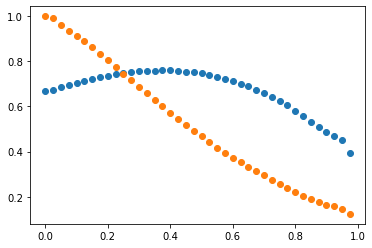

In [88]:
best_score, best_threshold = optimize_threshold(_oof, list(train_new["state"]))
print(best_score, best_threshold)

In [90]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

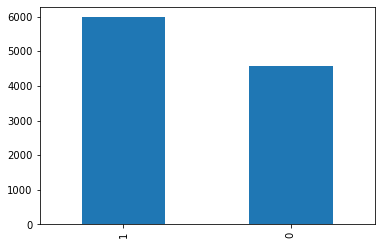

In [94]:
sub_file = making_sub(_preds, 0.4)
sub_file.to_csv(f"sub_files/optuna_lgbm_sub_{3}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")